In [1]:
import os
import shutil
from collections import defaultdict
import numpy as np
import cv2

TRAIN_SIZE_PER_CLASS = 20
MAX_TEST_SIZE_PER_CLASS = 5
MAX_CLASS_NUM = 50
CUT_SIZE = 81 * 81
RE_SIZE = (50, 50)
FEATURE_DIM = 900
FEAT_TYPE = 'downsample'

def random_face_feature_extractor(in_dim, out_dim):
    """随机特征提取矩阵 返回R 对于一维图像数据A RA表示一维图像特征 randomface"""
    R = np.random.randn(out_dim, in_dim)  # 每个元素服从正态分布
    R /= np.sum(R, axis=1, keepdims=True)  # 每一行表示一个randomface
    return R
    
def read_gray_cut_flatten_feat_from_img_path(img_path, feat_type, cut_range):
    img_gray = cv2.cvtColor(cv2.imread(data_path), cv2.COLOR_RGB2GRAY)[cut_range, cut_range]
    if feat_type == 'downsample':
        return cv2.resize(img_gray, RE_SIZE).flatten().astype(float)
    else:
        return np.dot(R, img_gray.flatten())
        
dataset_root_path = 'lfw-deepfunneled'  # 数据集目录 该目录下为 包含人类数据的文件夹 
#dataset_root_path = 'CroppedYale'
skip = 4 if dataset_root_path == 'CroppedYale' else 0  # 跳过无用文件
cut_range = slice(90, 171) if dataset_root_path == 'lfw-deepfunneled' else slice(None)
RE_SIZE = (50,50) if dataset_root_path == 'lfw-deepfunneled' else (12, 12)
R = random_face_feature_extractor(CUT_SIZE, FEATURE_DIM)  # randomfaces 特征

RA = []  # 字典矩阵
test_data = defaultdict(list) # 测试数据
class2index = {}  # 标签

# 数据处理 使用训练数据的特征拼接字典矩阵 准备测试数据的特征
for classi in os.listdir(dataset_root_path):
    class_data_path = os.path.join(dataset_root_path, classi)
    class_data = os.listdir(class_data_path)
    # 删除多余的文件
    if len(class_data) < skip + TRAIN_SIZE_PER_CLASS + 1 or len(test_data) == MAX_CLASS_NUM:
        shutil.rmtree(class_data_path)
        continue
    class2index[classi] = len(test_data)
    # 训练数据 从灰度图抽取特征RA_i后拼接成RA
    for d in class_data[skip:TRAIN_SIZE_PER_CLASS+skip]:
        data_path = os.path.join(class_data_path, d)
        RA.append(read_gray_cut_flatten_feat_from_img_path(data_path, feat_type=FEAT_TYPE, cut_range=cut_range))
    # 测试数据 从灰度图抽取特征RA_i后归入所属类别
    last = min(len(class_data), TRAIN_SIZE_PER_CLASS + skip + MAX_TEST_SIZE_PER_CLASS)
    for d in class_data[TRAIN_SIZE_PER_CLASS+skip:last]:
        data_path = os.path.join(class_data_path, d)
        test_data[classi].append(read_gray_cut_flatten_feat_from_img_path(data_path, feat_type=FEAT_TYPE, cut_range=cut_range))
    # 删除多余的文件
    if last < len(class_data):
        for d in class_data[last:]:
            os.remove(os.path.join(class_data_path, d))
            
RA = np.array(RA).transpose()  # 特征维度x数据量 每列是一个特征
RA /= np.sum(RA ** 2, axis = 0, keepdims=True) ** 0.5  # 每一列进行二范数单位化

print("---数据集信息---")
print("使用{}特征的表示字典大小为：".format(FEAT_TYPE), RA.shape, "，表示不同人脸的特征，每{}张人脸属于一个人".format(TRAIN_SIZE_PER_CLASS))
print("一共{}个类别, {}份测试数据".format(len(test_data), sum([len(test_data[i]) for i in test_data])))

---数据集信息---
使用downsample特征的表示字典大小为： (2500, 1000) ，表示不同人脸的特征，每20张人脸属于一个人
一共50个类别, 213份测试数据


In [2]:
import matplotlib.pyplot as plt
import cvxpy as cvx

def soft_threshold(threshold, x):
    return np.sign(x) * (x * (abs(x) - threshold) > 0)

def lasso_cvx(B, b, eps, epochs=100, display=False):
    """使用cvxpy 求解LASSO"""
    w = cvx.Variable(B.shape[1])
    cvx.Problem(cvx.Minimize(cvx.sum_squares(B@w - b)), [cvx.norm(w, 1) <= 1]).solve()
    return w.value

def lasso_admm(B, b, eps, epochs=1000, display=False):
    """使用交替方向乘子法 求解LASSO"""
    p = np.linalg.norm(b) / B.shape[0]
    c = 0.01 * p
    w = np.zeros(B.shape[1])
    best_w = None
    min_l = 0x3f3f3f3f
    y = w.copy()
    z = w.copy()
    I = np.eye(B.shape[1])
    if display:
        loss1, loss2 = [], []
    BTB_CI_1 = np.linalg.inv(np.dot(B.T, B) + c * I)
    BTb = np.dot(B.T, b)
    for _ in range(epochs):
        last_w = w
        w = np.dot(BTB_CI_1, BTb + c * (y - z))
        y = soft_threshold(p / c, z + w)
        z = z + w - y
        l1, l2 = 0.5 * np.linalg.norm(np.dot(B, w) - b), np.linalg.norm(w, ord=1)
        if l1 + l2 < min_l:
            min_l = l1 + l2
            best_w = w
        if display:
            loss1.append(l1)
            loss2.append(l2)
        if np.linalg.norm(w - last_w) < eps:
            break
    if display:
        plt.plot(loss1, label='1/2||Bw-b||')
        plt.plot(loss2, label='p||w||')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
    return best_w

def lasso_dalm(B, b, eps, epochs=1000, display=False):
    """使用对偶增广拉格朗日法 求解LASSO"""
    w = np.zeros(B.shape[1])
    y = np.zeros(B.shape[0])
    A = B[:, :-B.shape[0]] * (2 ** 0.5)
    G = (np.dot(A, A.T) + np.eye(B.shape[0])) / 2
    invG = np.linalg.inv(G)
    invG_Av = np.dot(invG, B)
    invG_bv = np.dot(invG, b)
    beta = np.linalg.norm(b) / B.shape[0]
    if display:
        loss1, loss2 = [], []
    BTy = np.dot(B.T, y)
    for _ in range(epochs):
        z = (BTy + w / beta)
        z[abs(z) > 1] = np.sign(z)[abs(z) > 1]
        
        y = np.dot(invG_Av, (z - w / beta)) + invG_bv / beta
        BTy = np.dot(B.T, y)
        
        last_w = w
        w = w - beta * (z - BTy)
        if display:
            loss1.append(0.5 * np.linalg.norm(np.dot(B, w) - b))
            loss2.append(np.linalg.norm(w, ord=1))
        if np.linalg.norm(w - last_w) < eps:
            break
    if display:
        plt.plot(loss1, label='1/2||Bw-b||')
        plt.plot(loss2, label='p||w||')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()
    return w    

In [3]:
def sparse_representation_classify(A, y, eps, num_class, lasso_solver, display=False):
    B = np.append(A, np.eye(A.shape[0]), axis=1) / (2 ** 0.5)  # [A I]单位化
    y = (y / (np.sum(y ** 2) ** 0.5)) / (2 ** 0.5)
    assert A.shape[1] % num_class == 0
    class_size = A.shape[1] // num_class
    w = lasso_solver(B, y, eps, display=display)
    x, e = w[:A.shape[1]], w[A.shape[1]:]
    y_r = y - e
    residual = []
    ans = 0
    for i in range(0, num_class):
        x_i = x * [x[j] if j // class_size == i else 0 for j in range(len(x))]
        residual_i = np.linalg.norm(y_r - A.dot(x_i))
        residual.append(residual_i)
        if residual_i < residual[ans]:
            ans = i
    if display:
        plt.subplot(211)
        plt.plot(range(len(x)), x)
        plt.ylabel('coefficient')
        plt.xlabel('represent dict')
        plt.subplot(212)
        plt.bar(range(len(residual)), residual)
        plt.ylabel('residual')
        plt.xlabel('class')
        plt.show()
    return ans

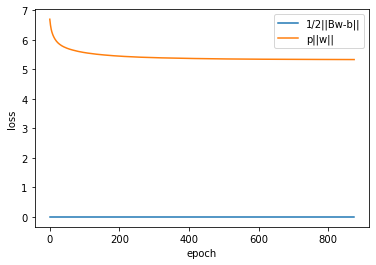

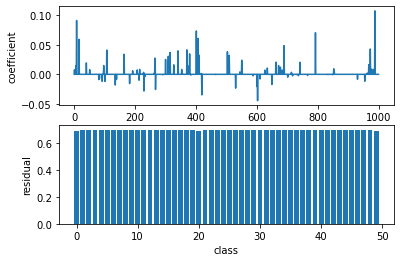

1.0


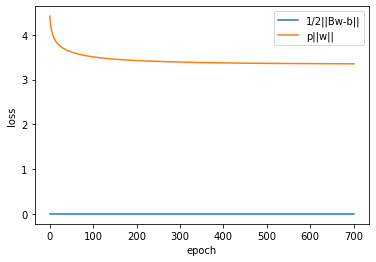

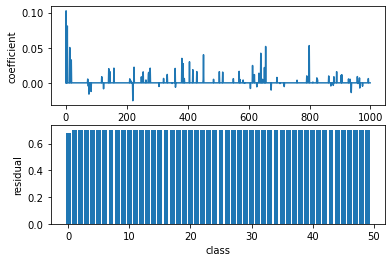

1.0


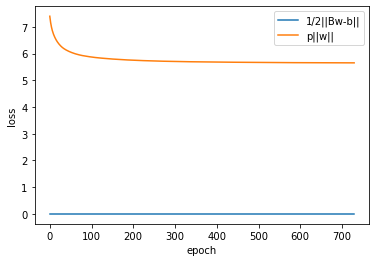

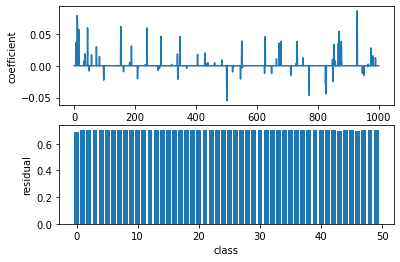

1.0


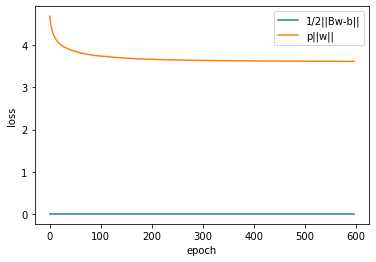

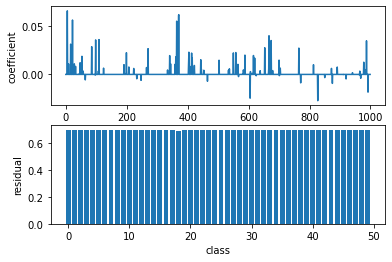

0.75


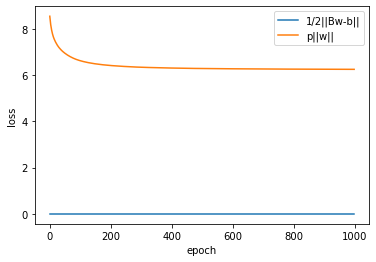

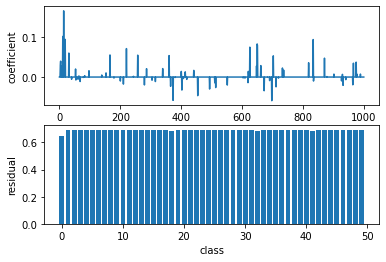

0.8


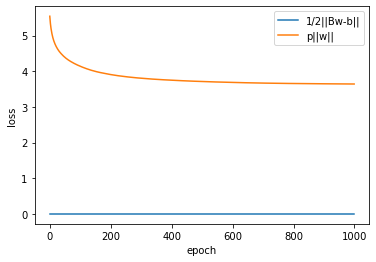

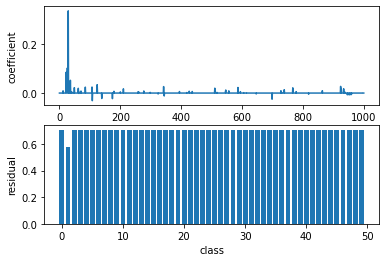

0.8333333333333334


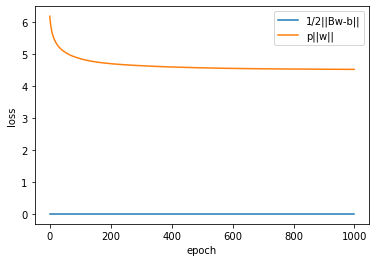

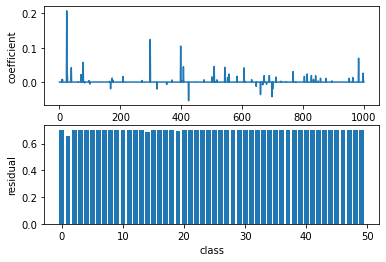

0.8571428571428571


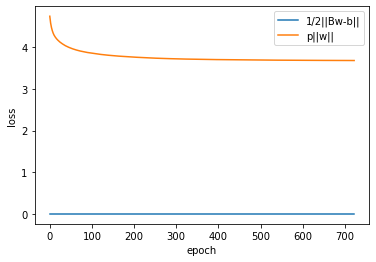

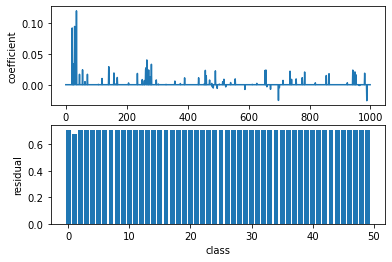

0.875


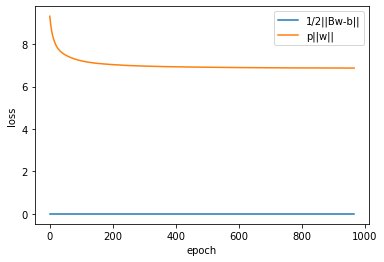

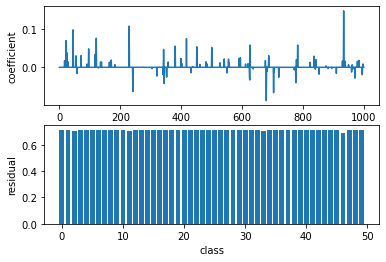

0.7777777777777778


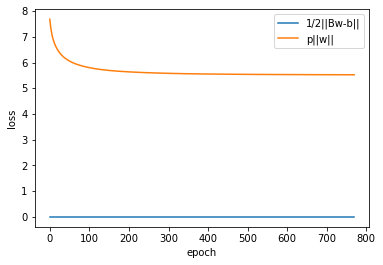

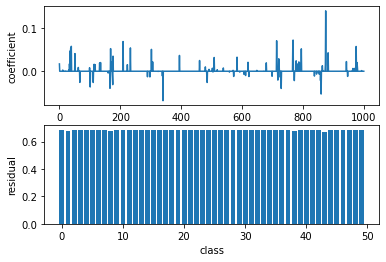

0.7


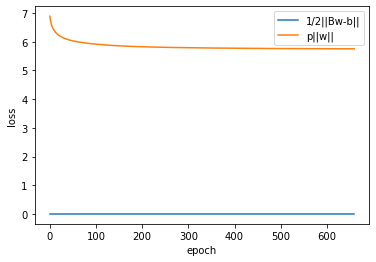

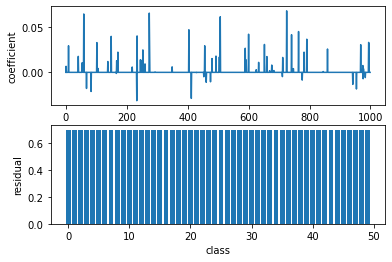

0.6363636363636364


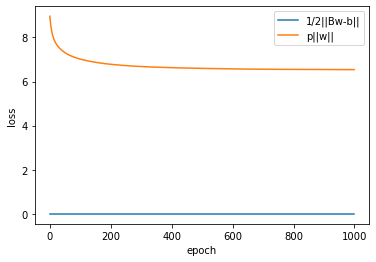

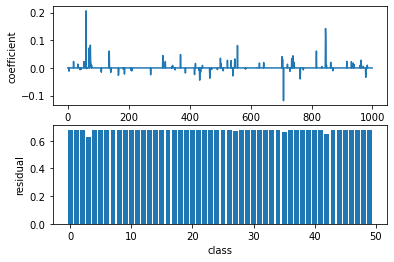

0.6666666666666666


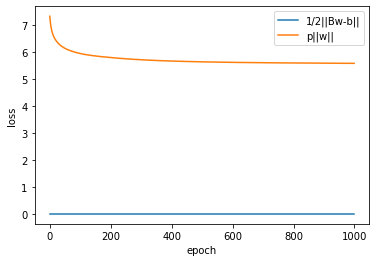

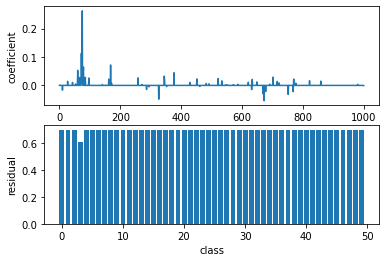

0.6923076923076923


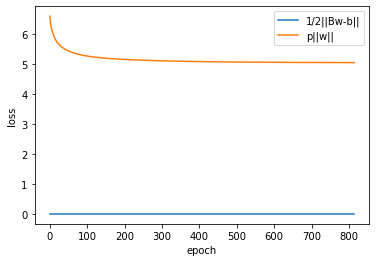

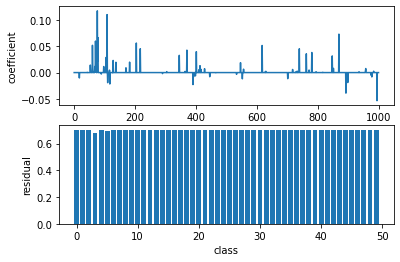

0.7142857142857143


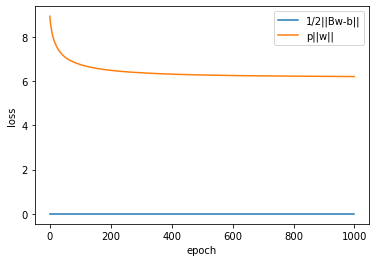

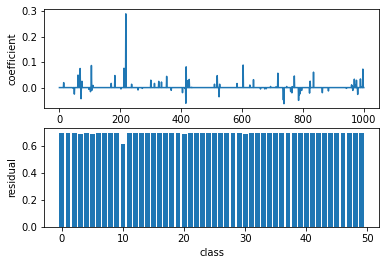

0.6666666666666666


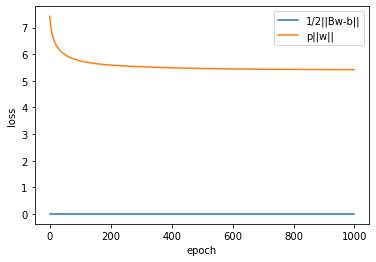

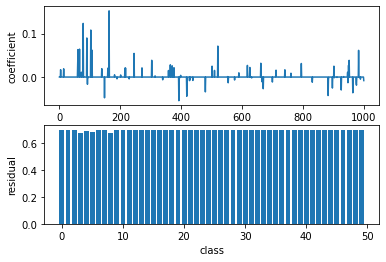

0.625


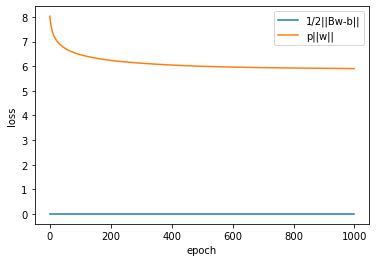

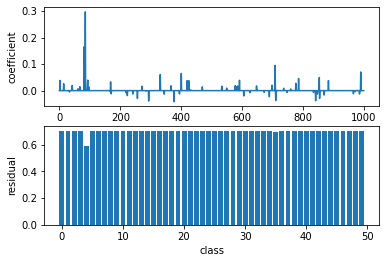

0.6470588235294118


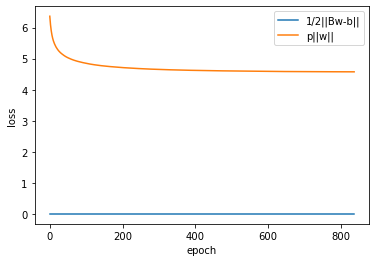

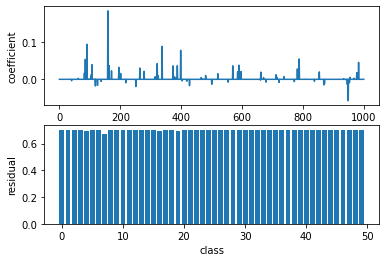

0.6111111111111112


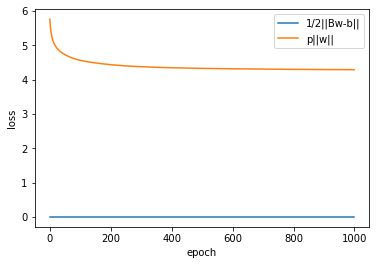

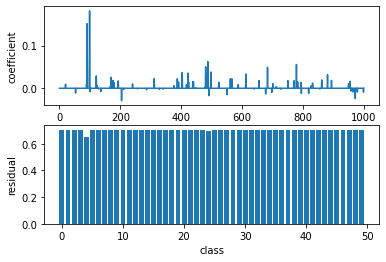

0.631578947368421


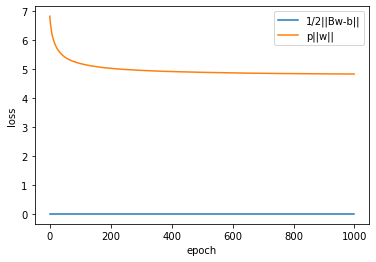

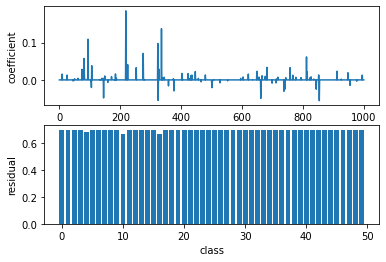

0.6


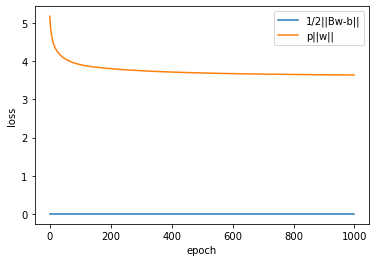

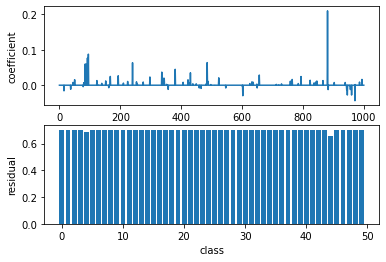

0.5714285714285714


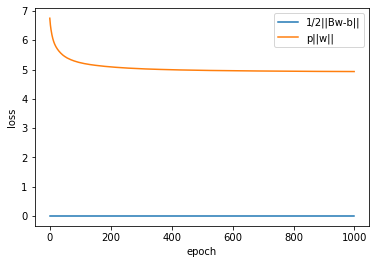

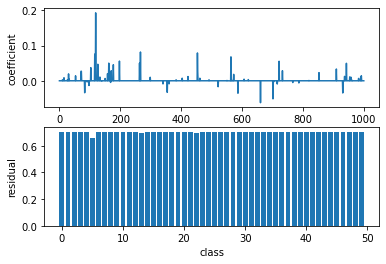

0.5909090909090909


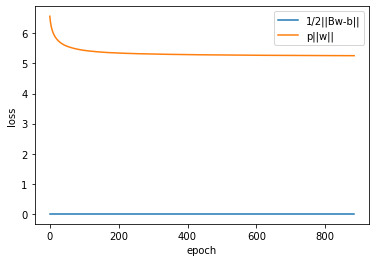

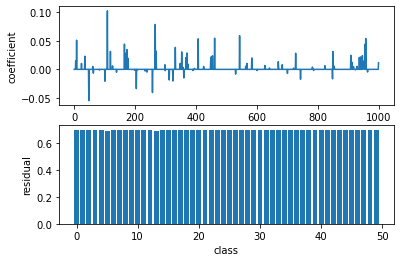

0.6086956521739131


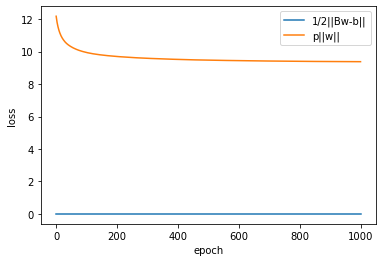

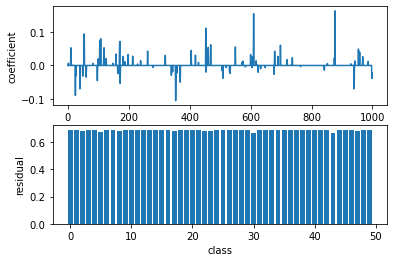

0.5833333333333334


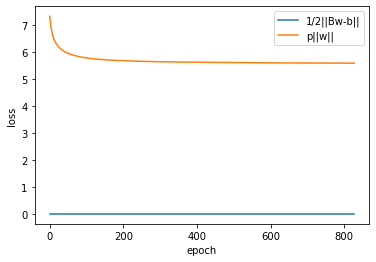

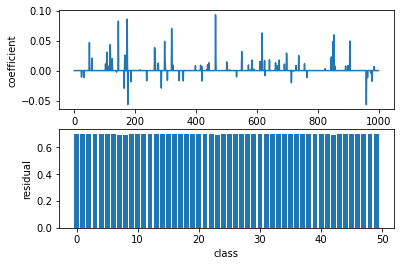

0.56


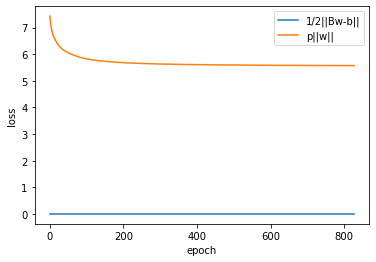

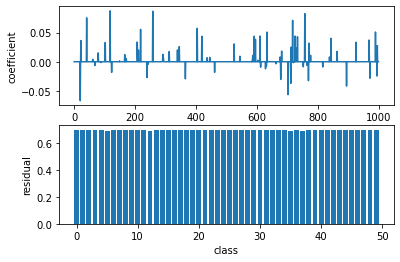

0.5384615384615384


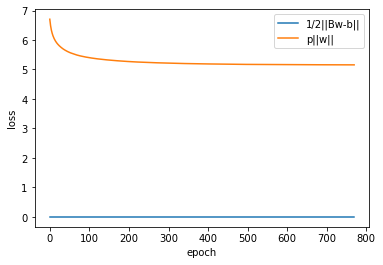

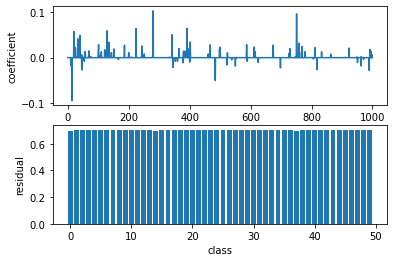

0.5185185185185185


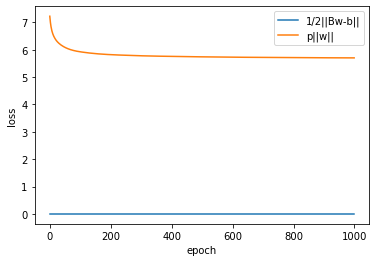

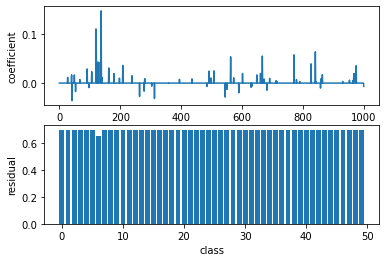

0.5357142857142857


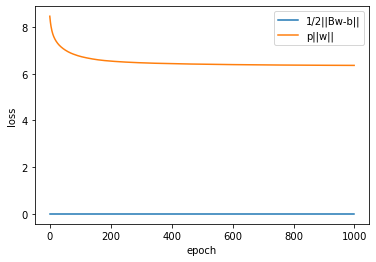

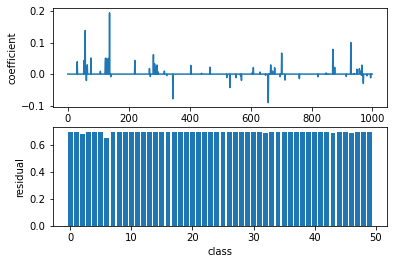

0.5517241379310345


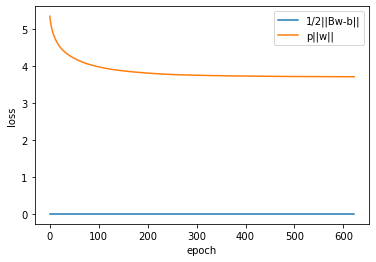

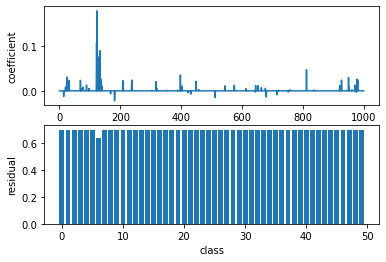

0.5666666666666667


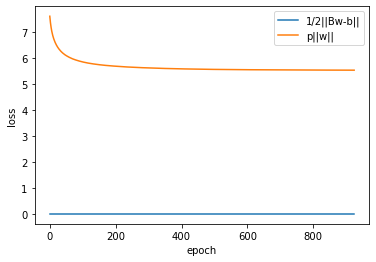

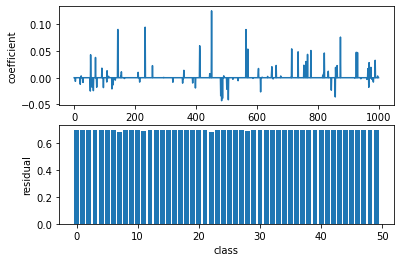

0.5806451612903226


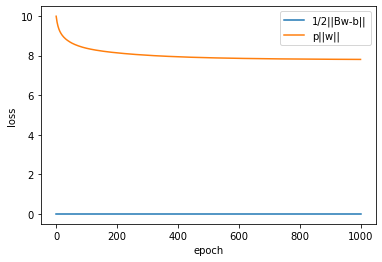

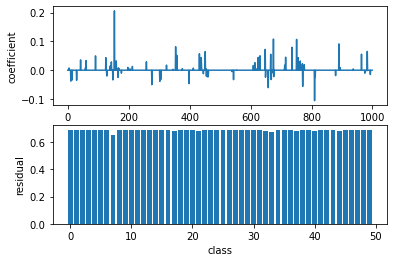

0.59375


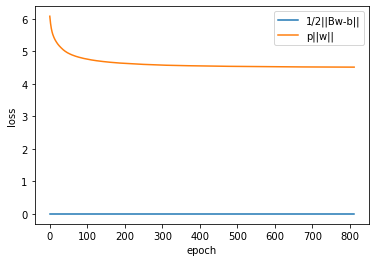

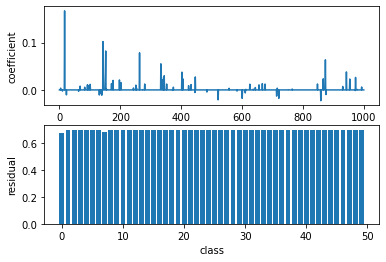

0.5757575757575758


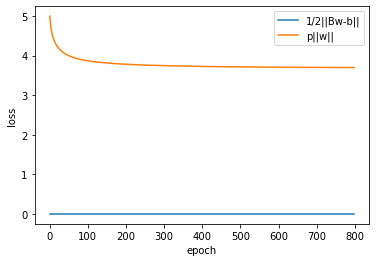

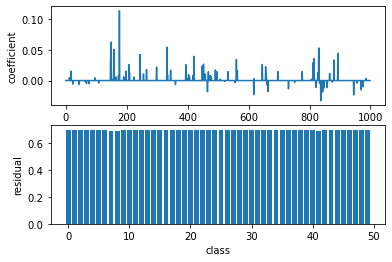

0.5588235294117647


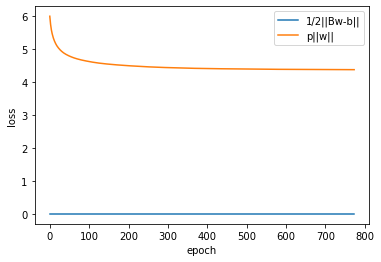

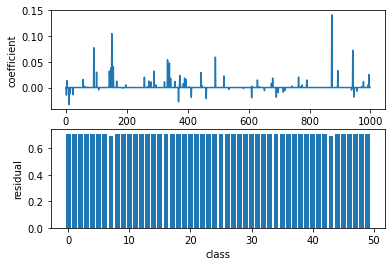

0.5714285714285714


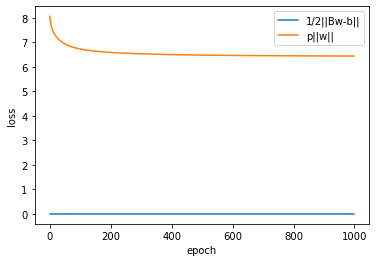

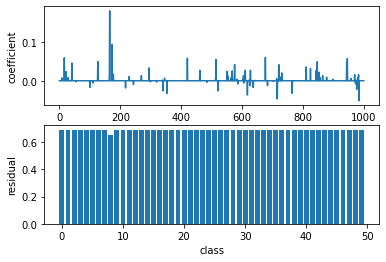

0.5833333333333334


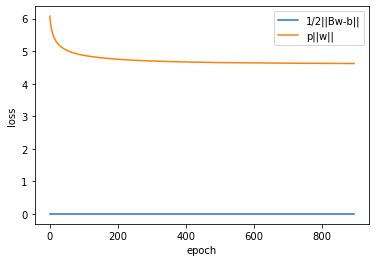

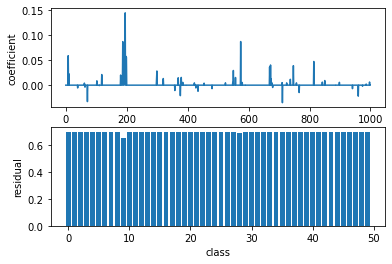

0.5945945945945946


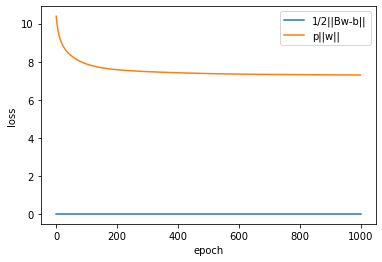

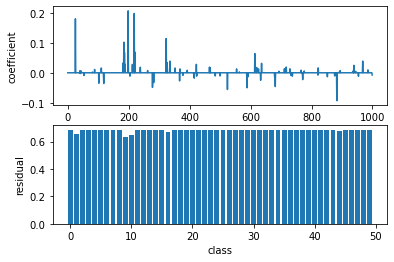

0.6052631578947368


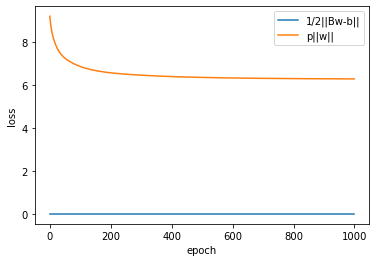

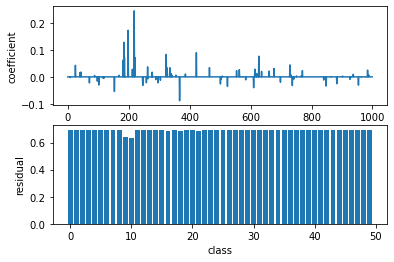

0.5897435897435898


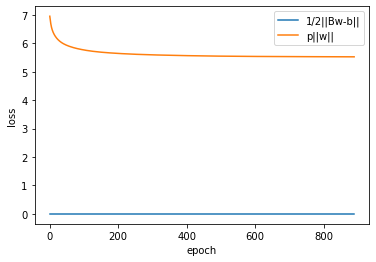

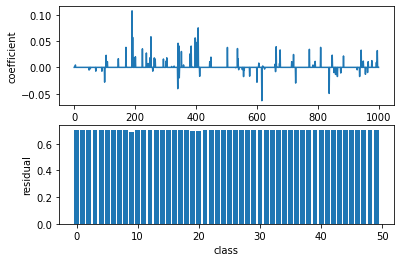

0.6


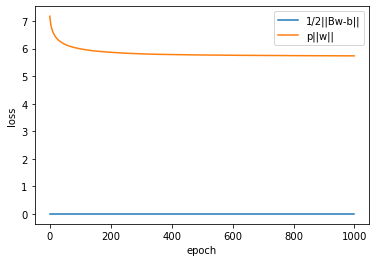

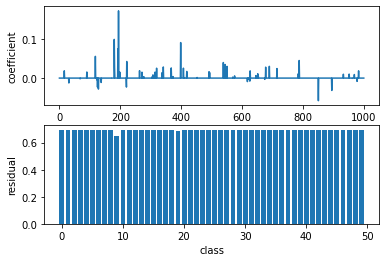

0.6097560975609756


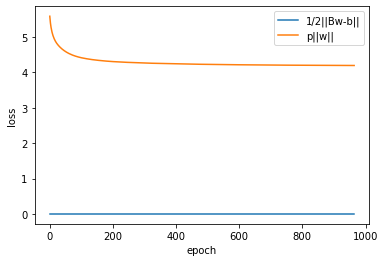

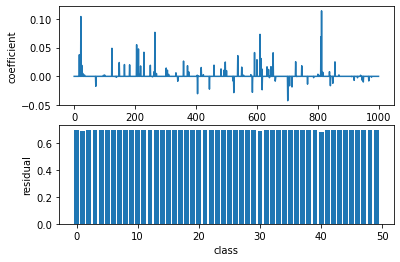

0.5952380952380952


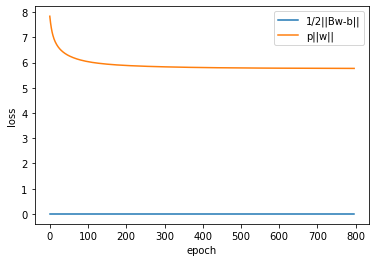

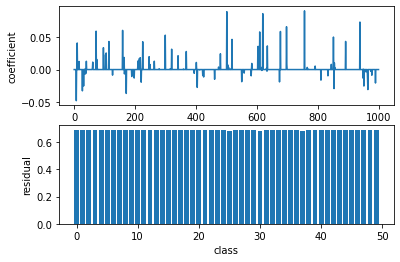

0.5813953488372093


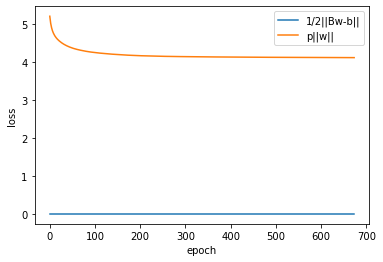

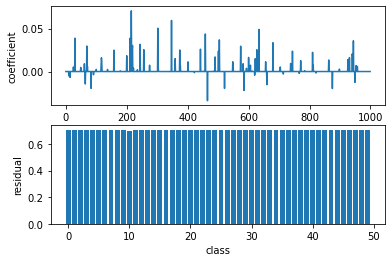

0.5909090909090909


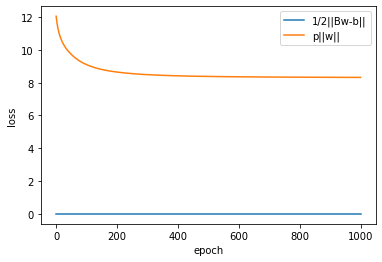

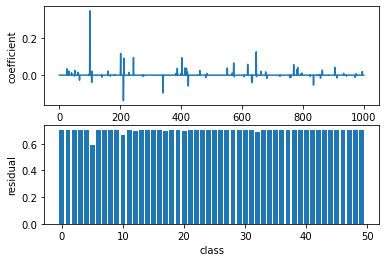

0.5777777777777777


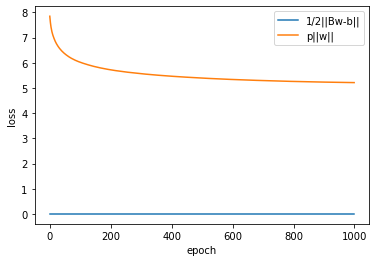

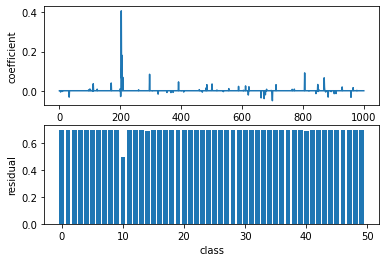

0.5869565217391305


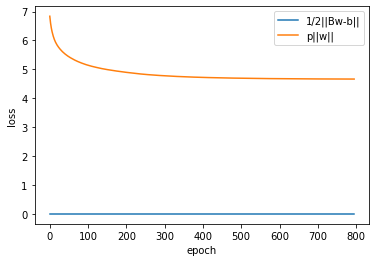

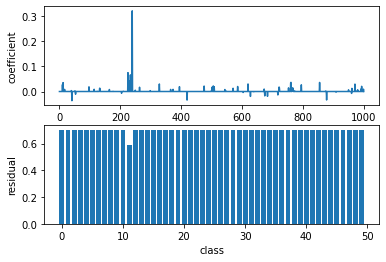

0.5957446808510638


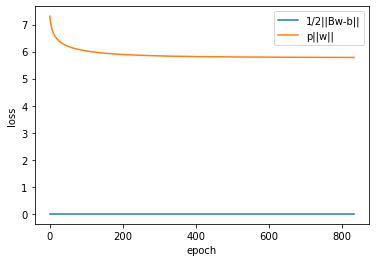

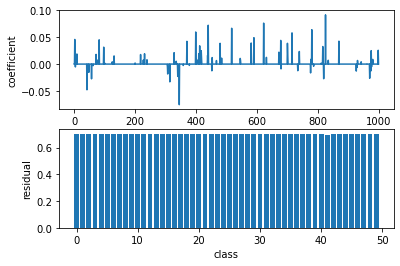

0.5833333333333334


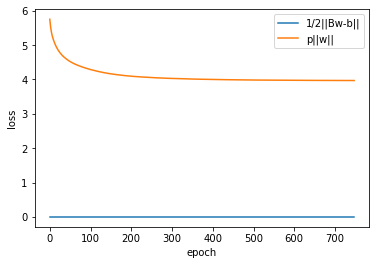

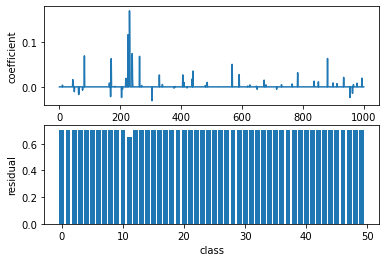

0.5918367346938775


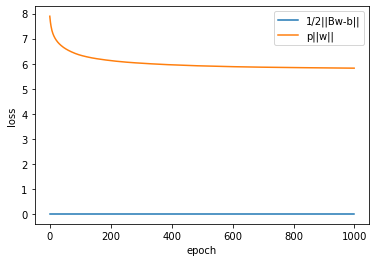

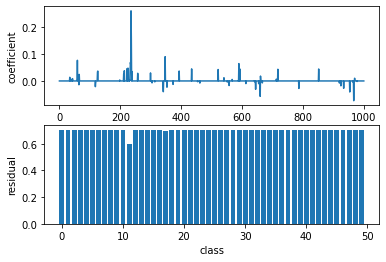

0.6


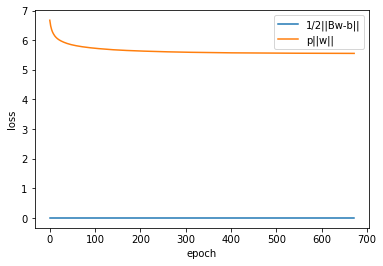

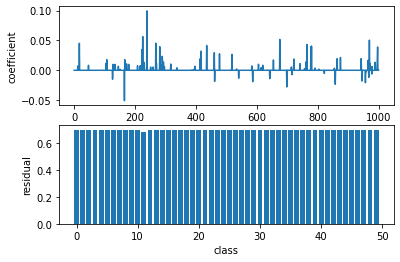

0.6078431372549019


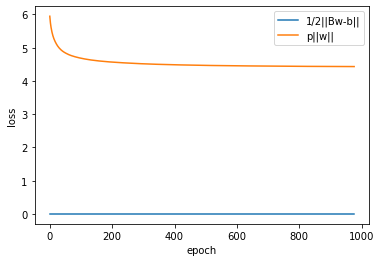

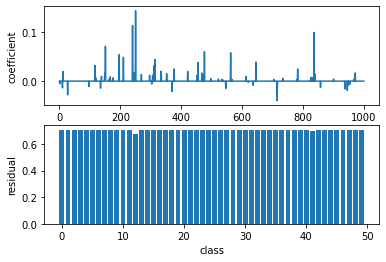

0.6153846153846154


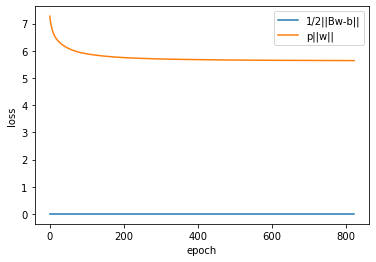

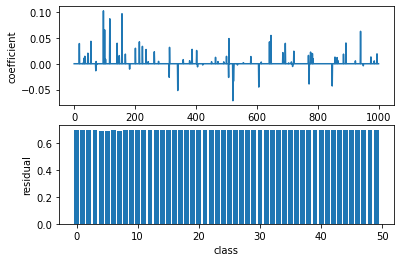

0.6037735849056604


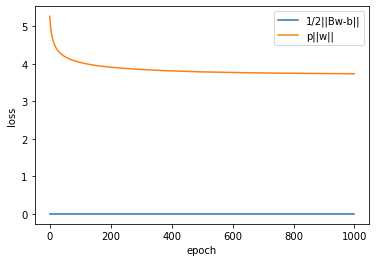

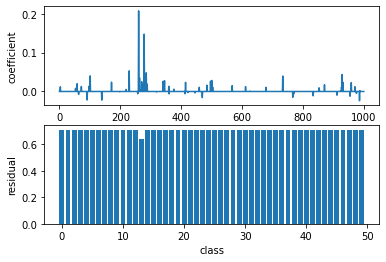

0.6111111111111112


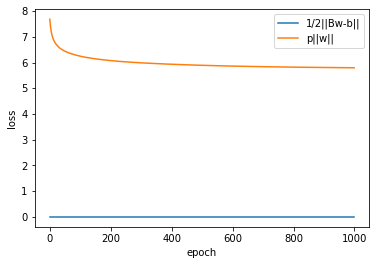

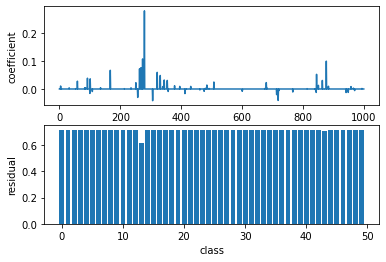

0.6181818181818182


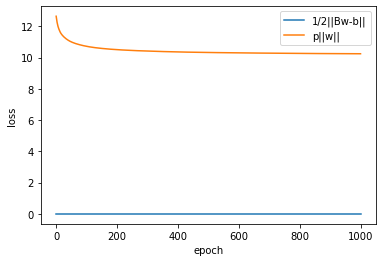

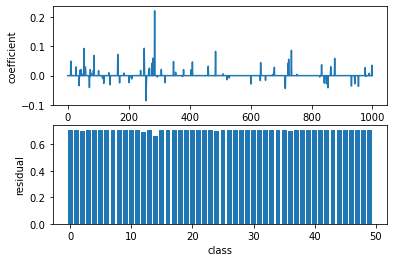

0.6071428571428571


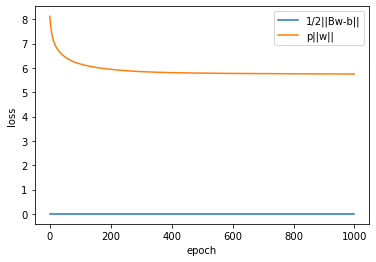

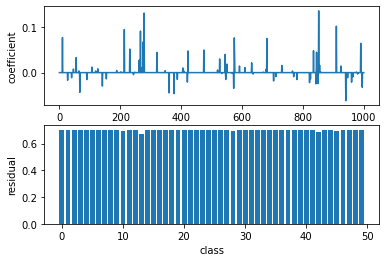

0.6140350877192983


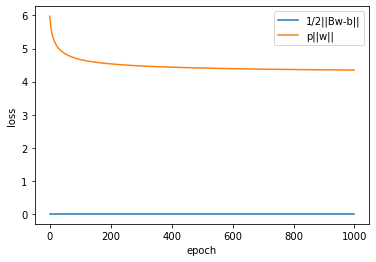

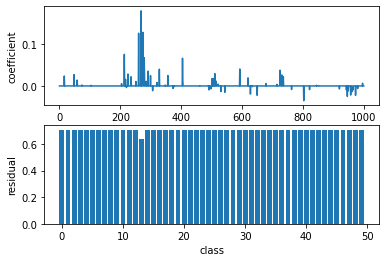

0.6206896551724138


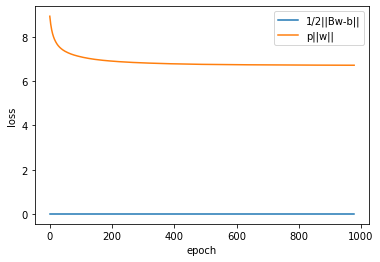

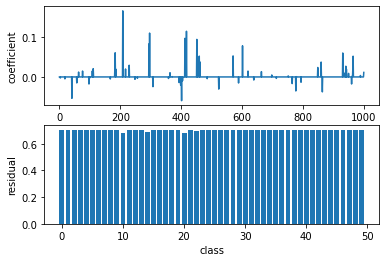

0.6101694915254238


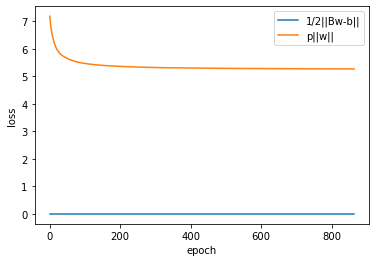

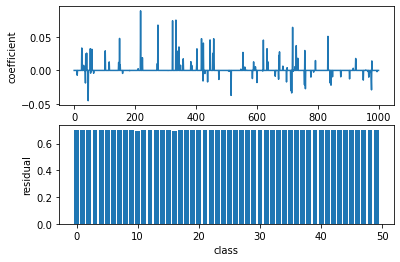

0.6


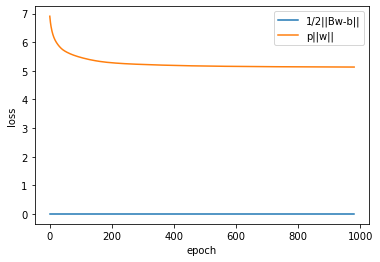

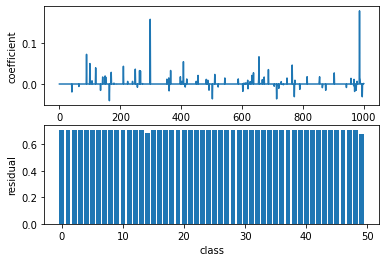

0.5901639344262295


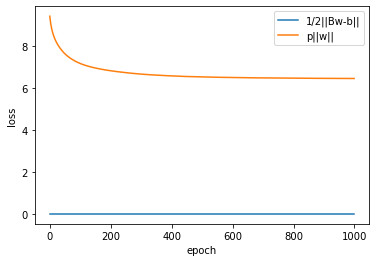

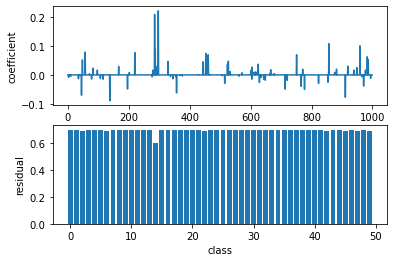

0.5967741935483871


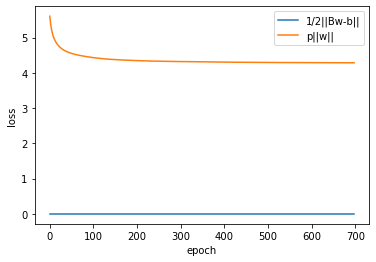

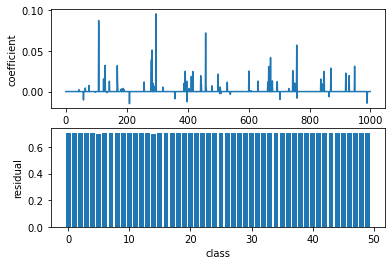

0.6031746031746031


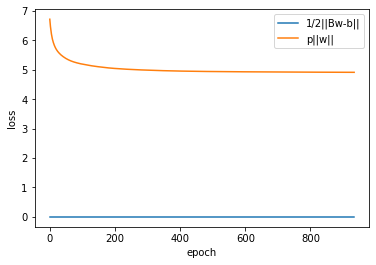

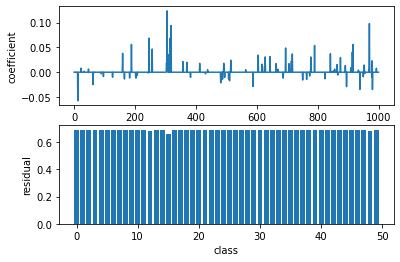

0.609375


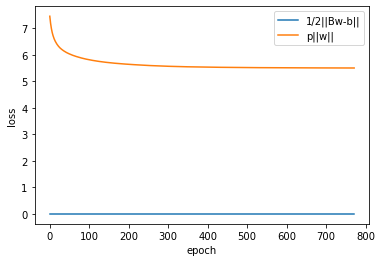

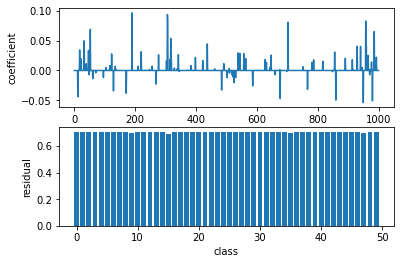

0.6153846153846154


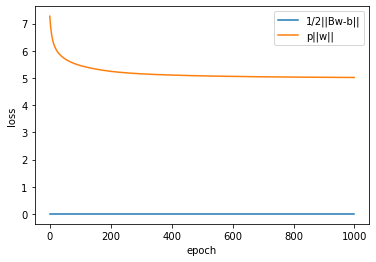

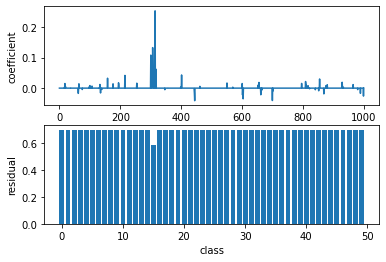

0.6212121212121212


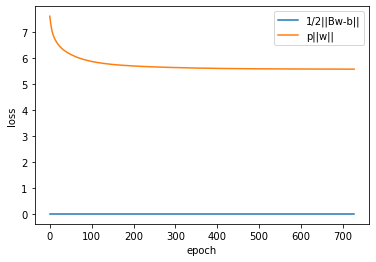

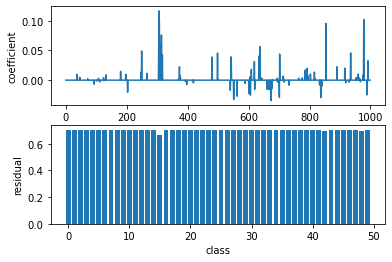

0.6268656716417911


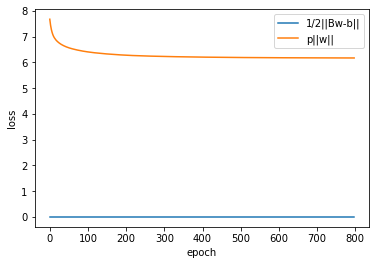

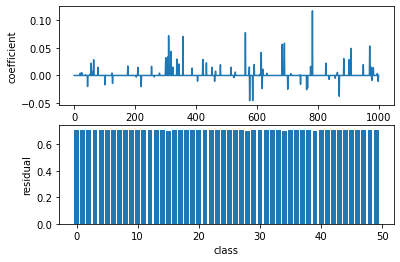

0.6176470588235294


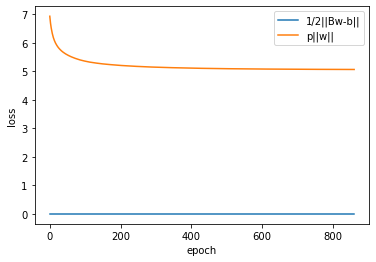

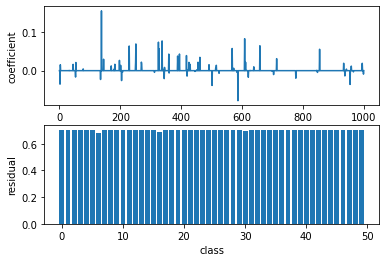

0.6086956521739131


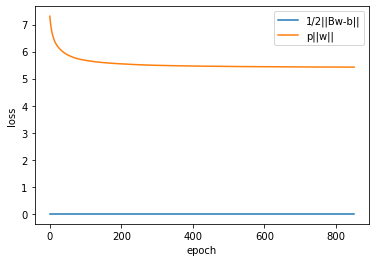

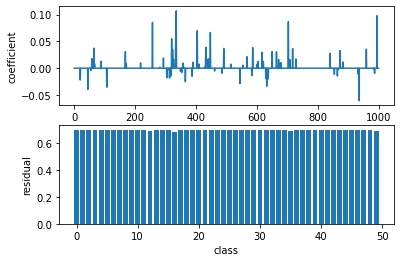

0.6142857142857143


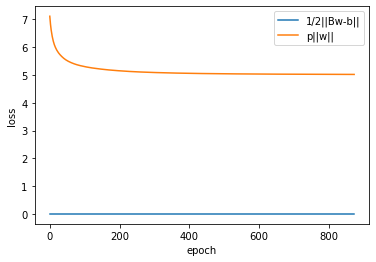

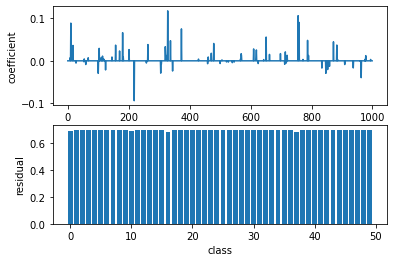

0.6056338028169014


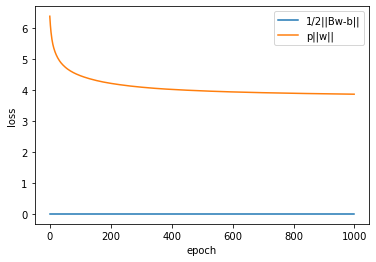

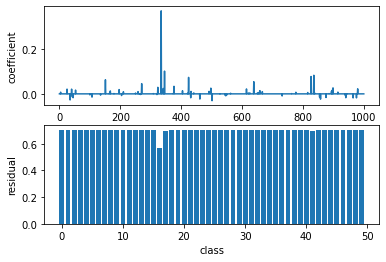

0.6111111111111112


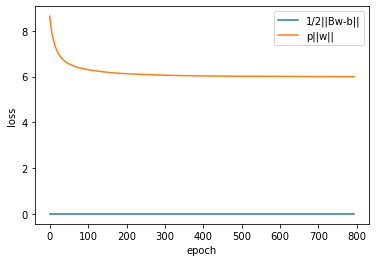

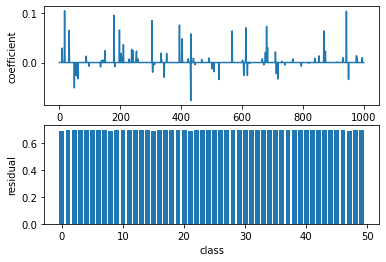

0.6027397260273972


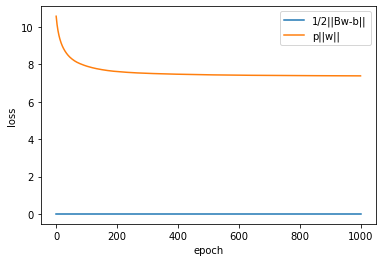

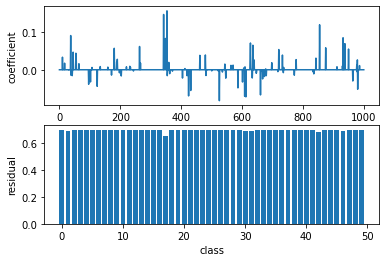

0.6081081081081081


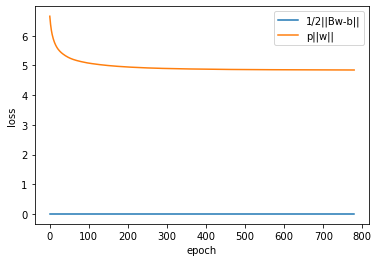

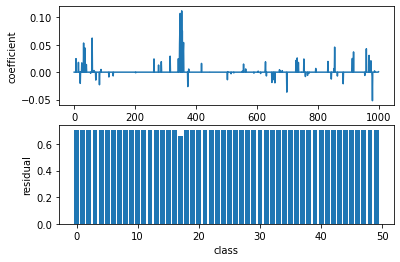

0.6133333333333333


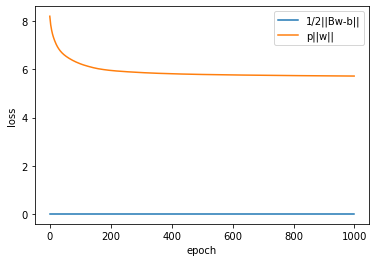

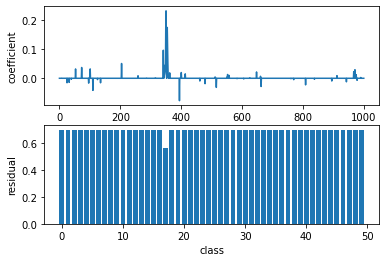

0.618421052631579


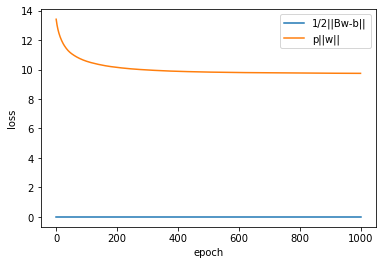

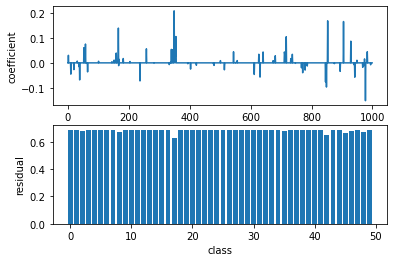

0.6233766233766234


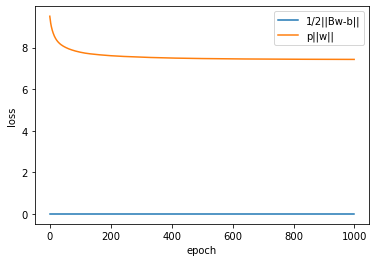

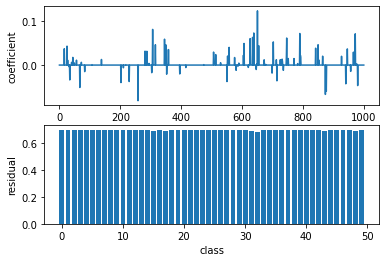

0.6153846153846154


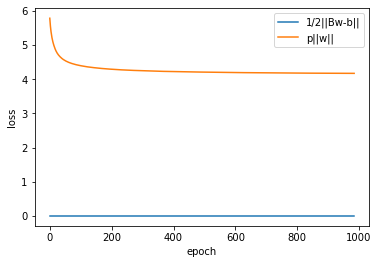

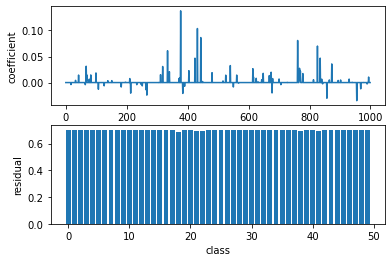

0.620253164556962


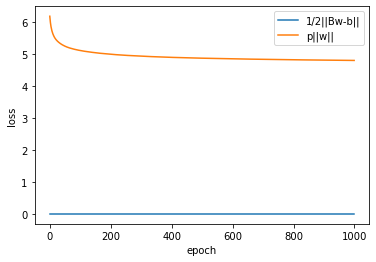

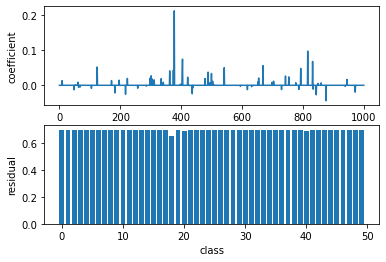

0.625


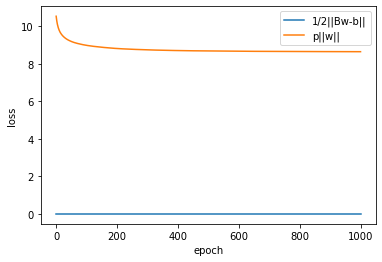

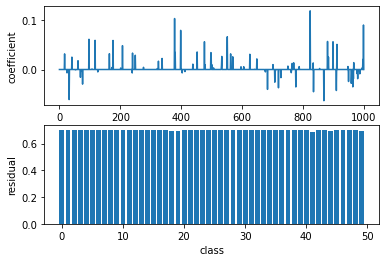

0.6172839506172839


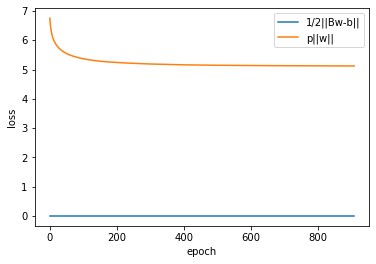

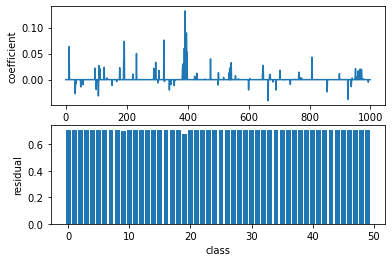

0.6219512195121951


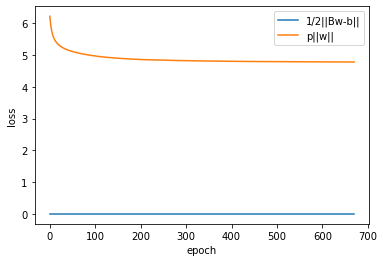

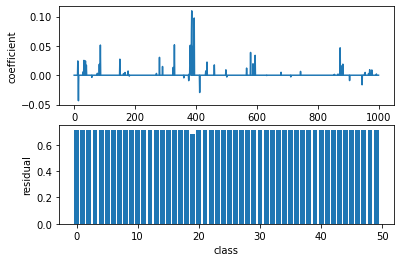

0.6265060240963856


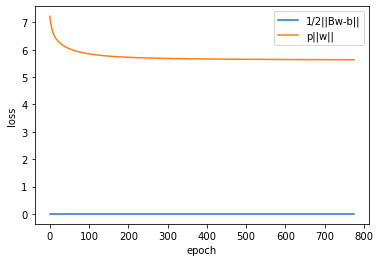

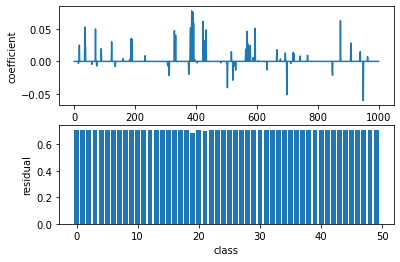

0.6309523809523809


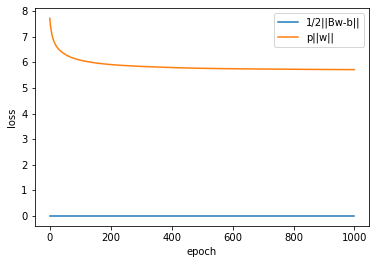

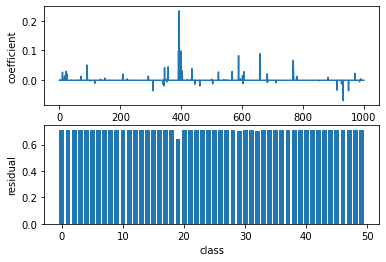

0.6352941176470588


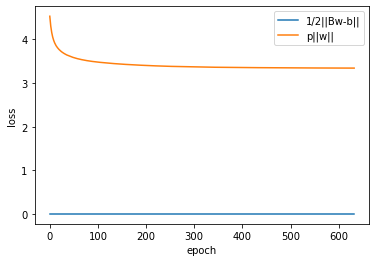

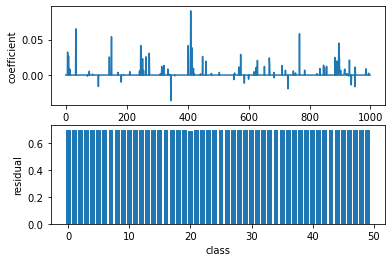

0.6395348837209303


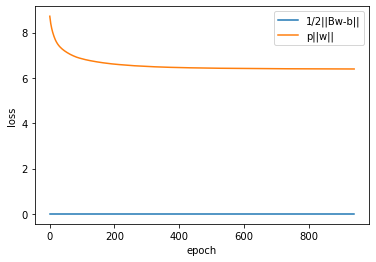

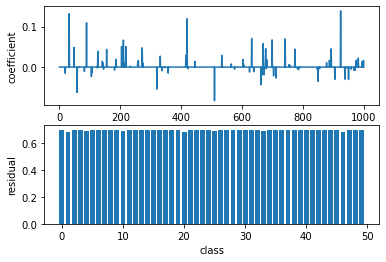

0.632183908045977


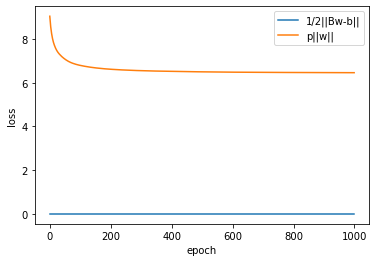

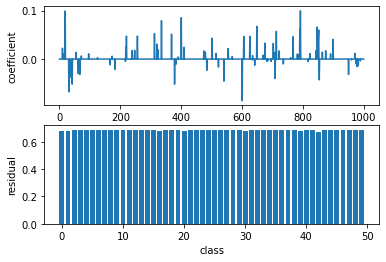

0.625


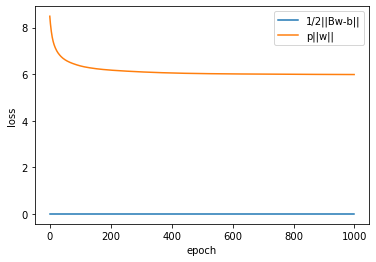

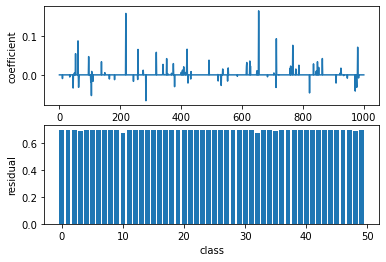

0.6179775280898876


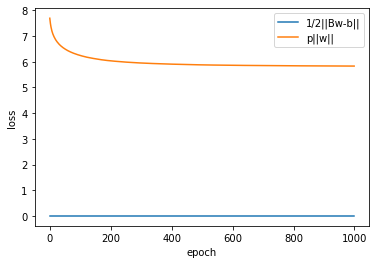

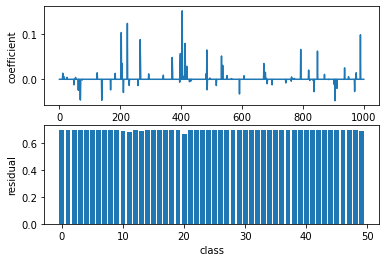

0.6222222222222222


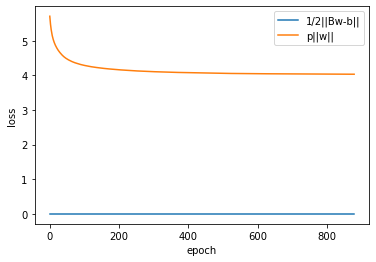

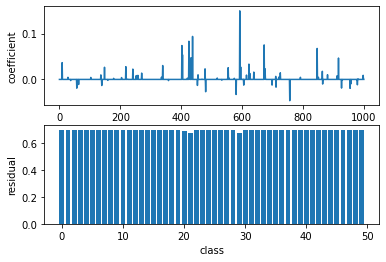

0.6153846153846154


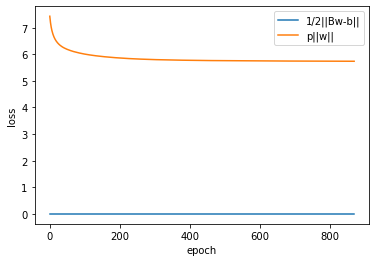

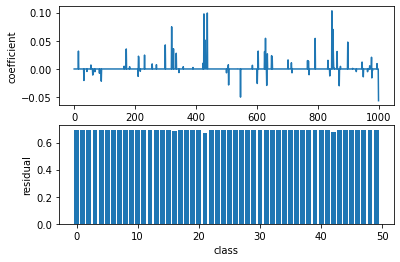

0.6195652173913043


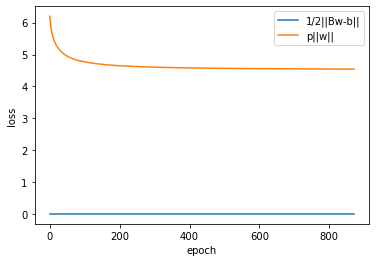

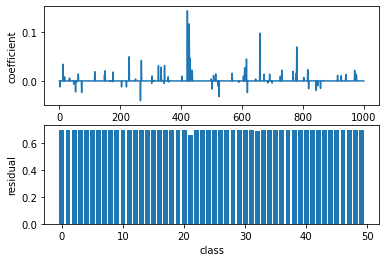

0.6236559139784946


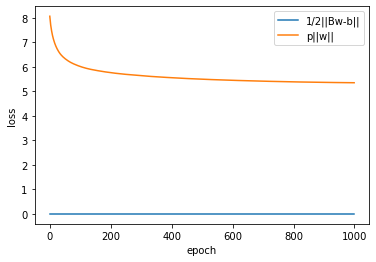

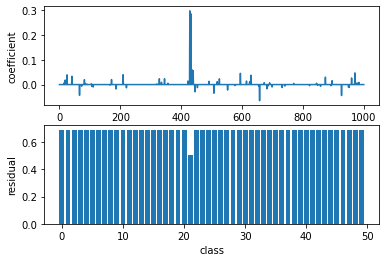

0.6276595744680851


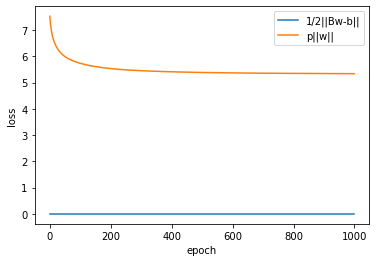

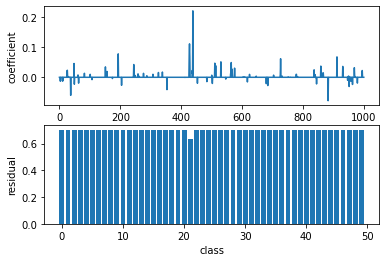

0.631578947368421


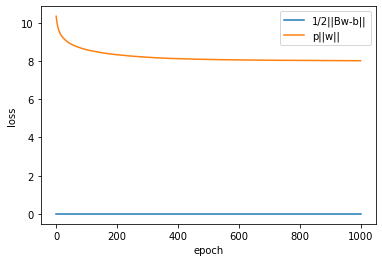

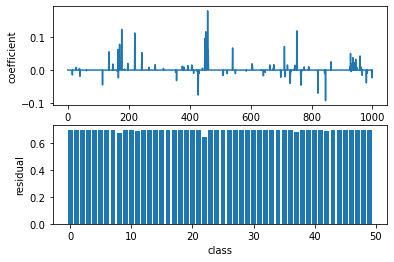

0.6354166666666666


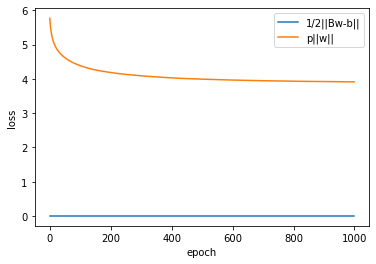

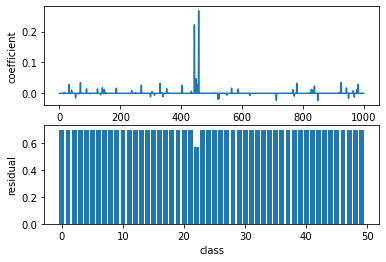

0.6391752577319587


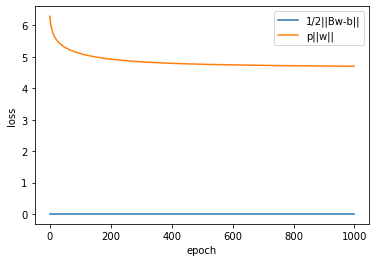

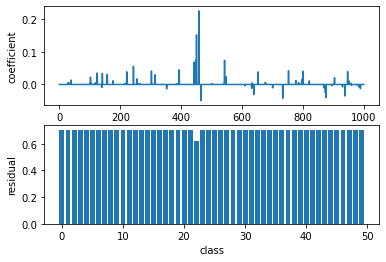

0.6428571428571429


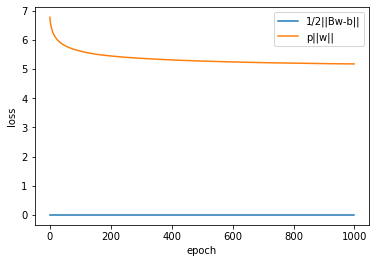

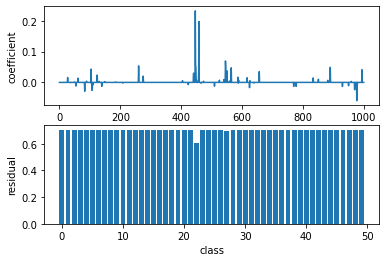

0.6464646464646465


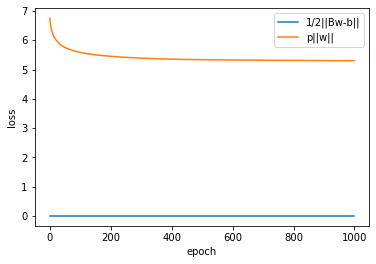

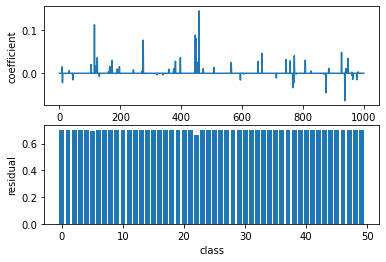

0.65


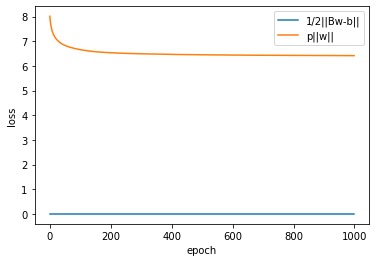

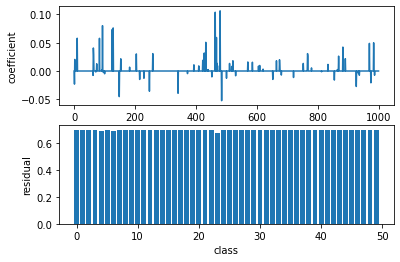

0.6534653465346535


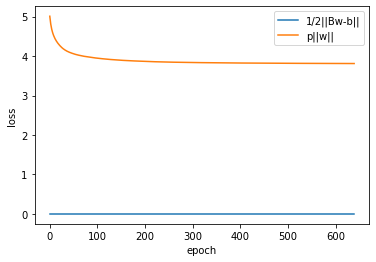

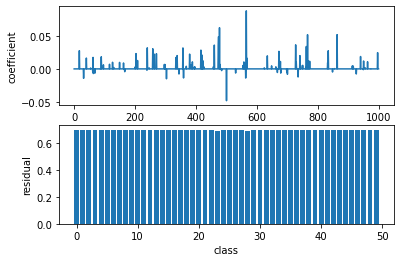

0.6568627450980392


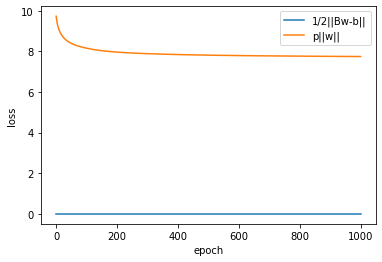

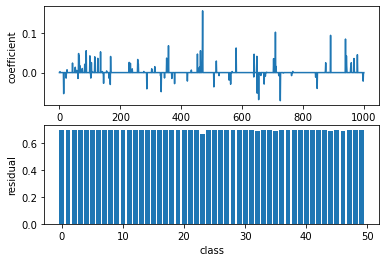

0.6601941747572816


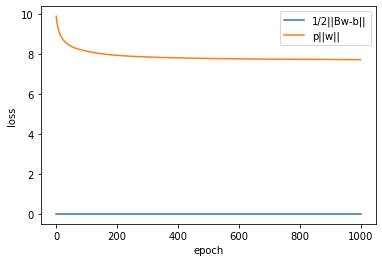

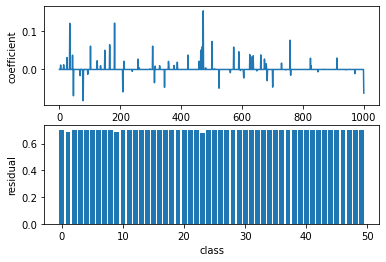

0.6634615384615384


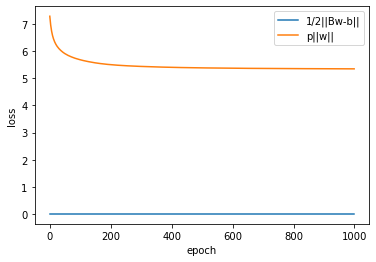

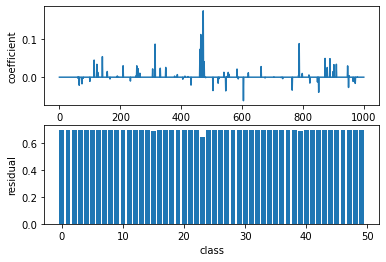

0.6666666666666666


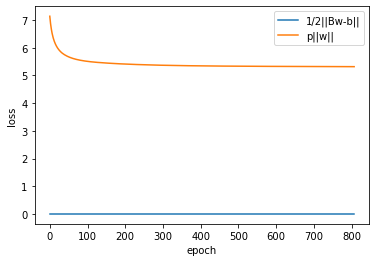

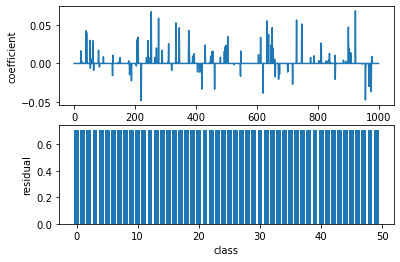

0.660377358490566


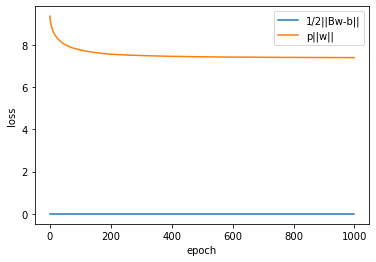

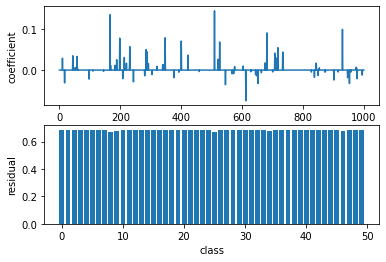

0.6635514018691588


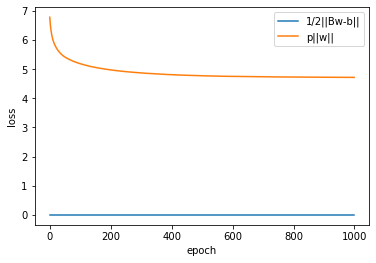

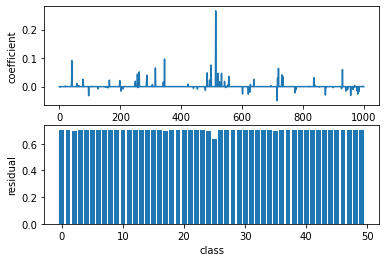

0.6666666666666666


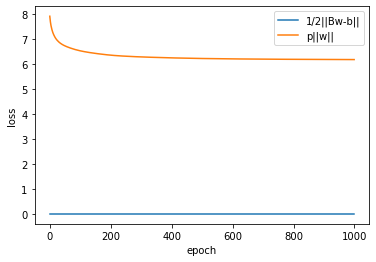

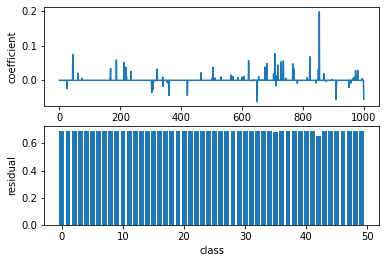

0.6605504587155964


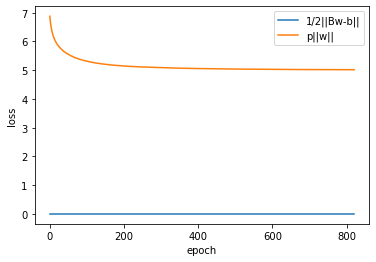

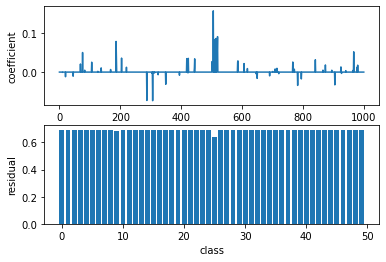

0.6636363636363637


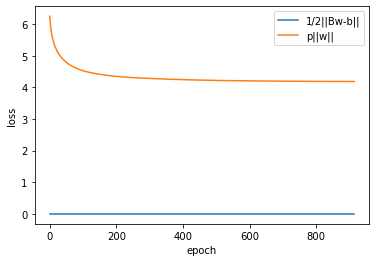

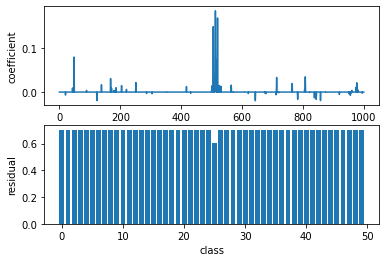

0.6666666666666666


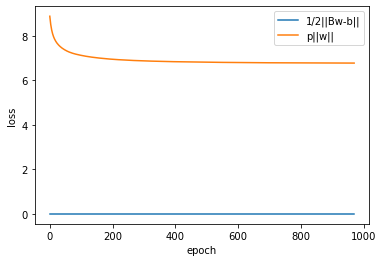

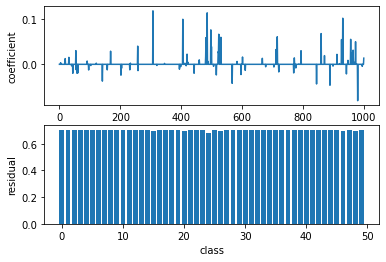

0.6607142857142857


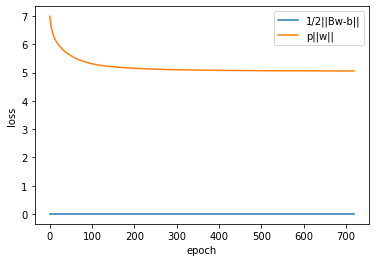

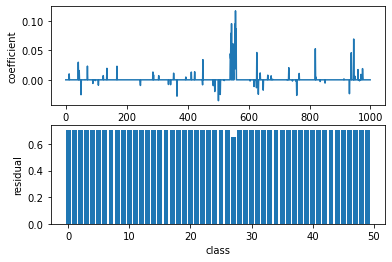

0.6637168141592921


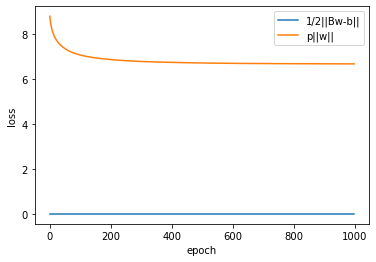

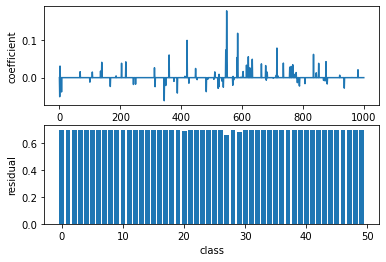

0.6666666666666666


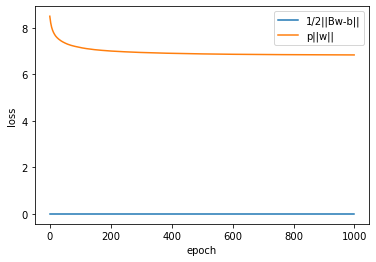

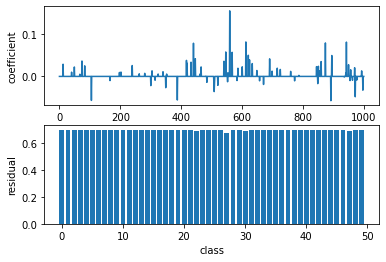

0.6695652173913044


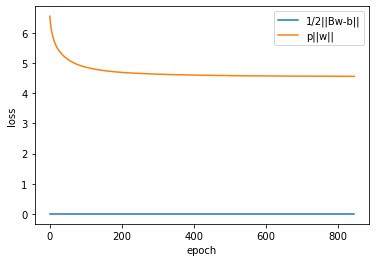

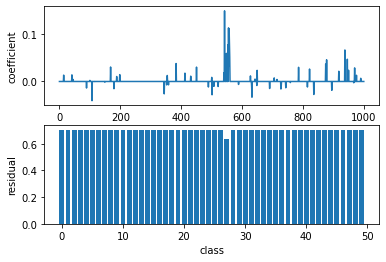

0.6724137931034483


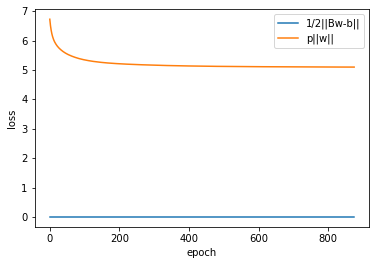

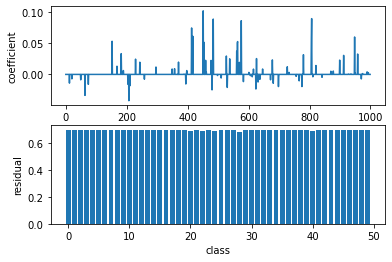

0.6752136752136753


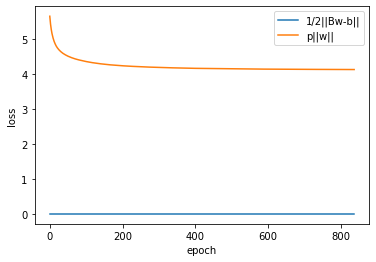

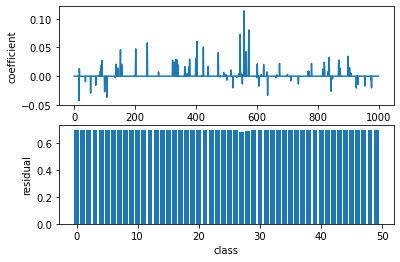

0.6694915254237288


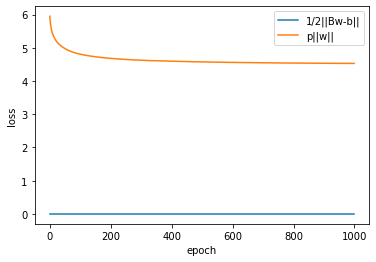

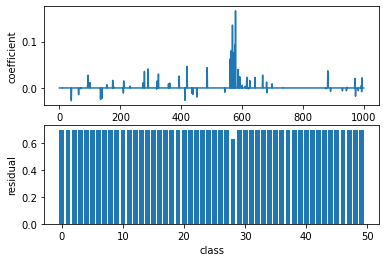

0.6722689075630253


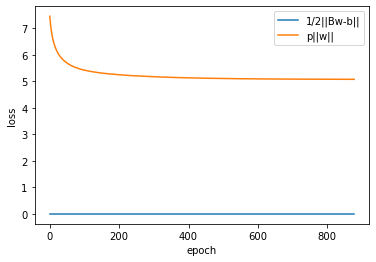

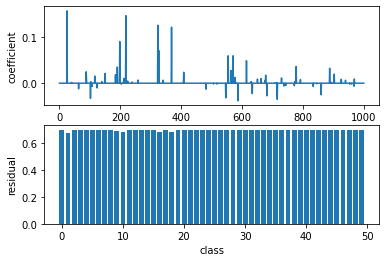

0.6666666666666666


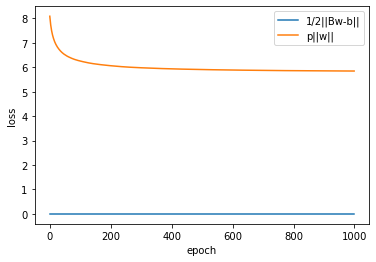

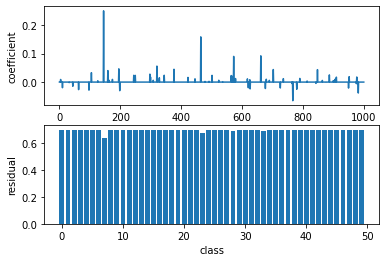

0.6611570247933884


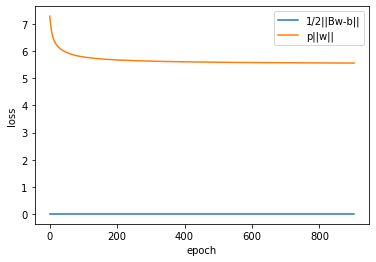

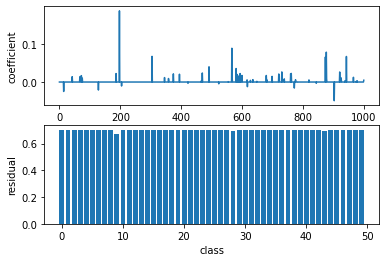

0.6557377049180327


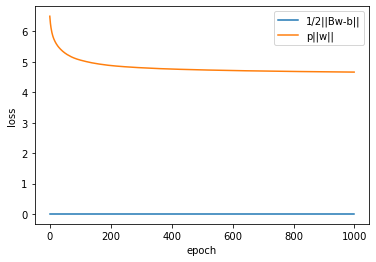

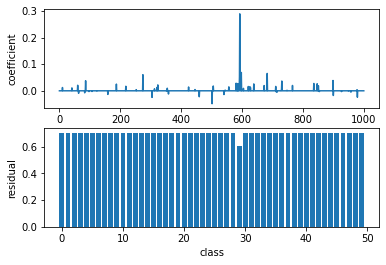

0.6585365853658537


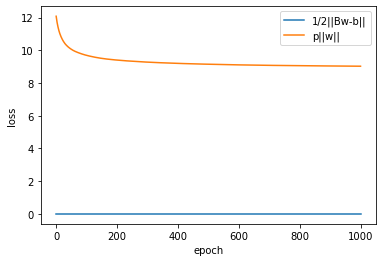

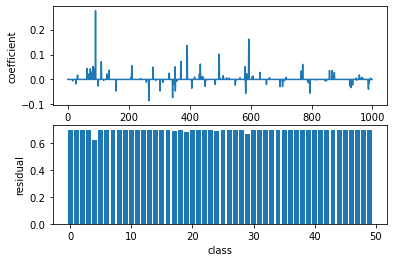

0.6532258064516129


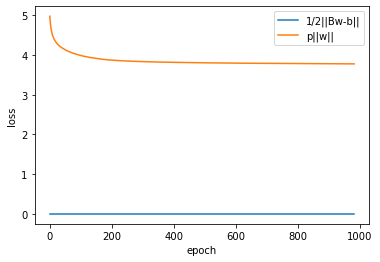

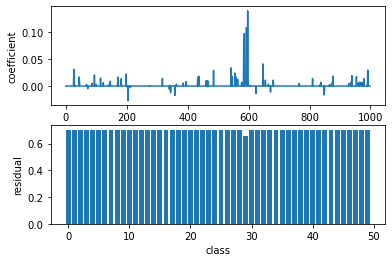

0.656


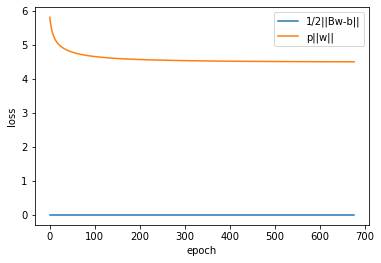

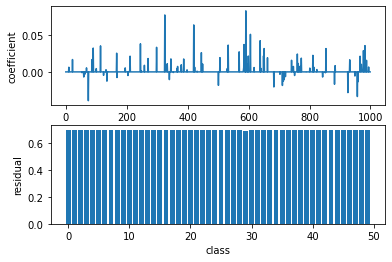

0.6587301587301587


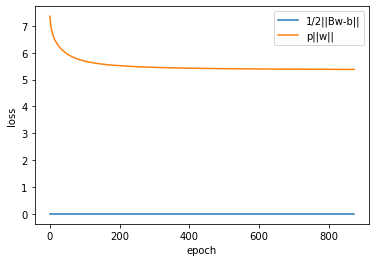

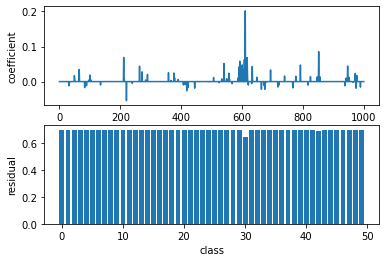

0.6614173228346457


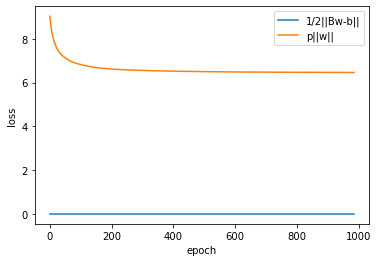

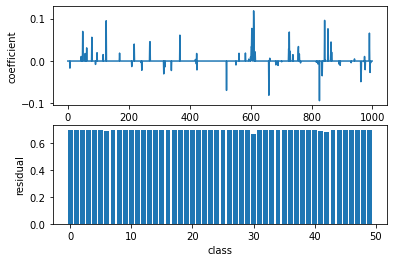

0.6640625


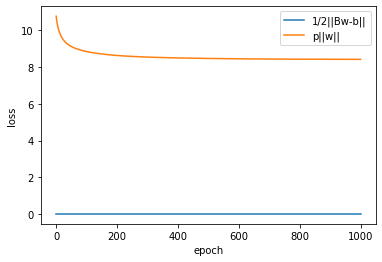

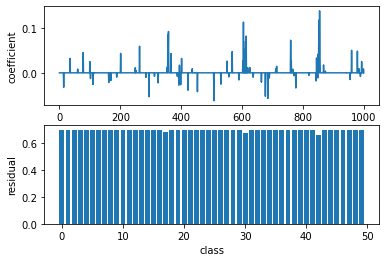

0.6589147286821705


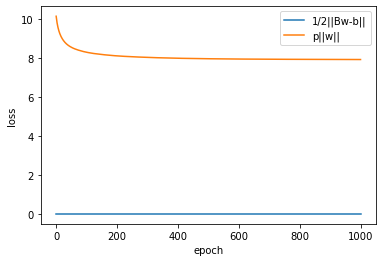

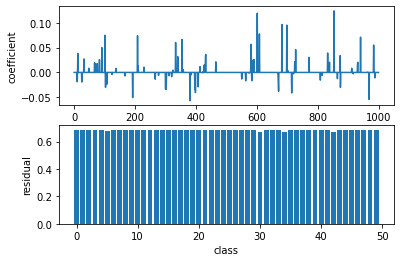

0.6538461538461539


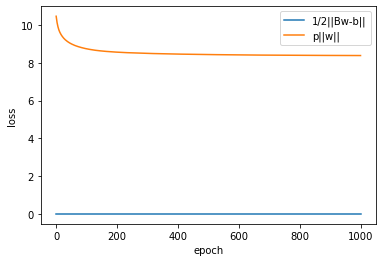

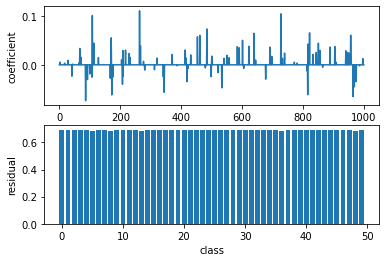

0.648854961832061


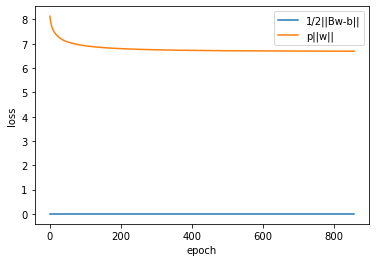

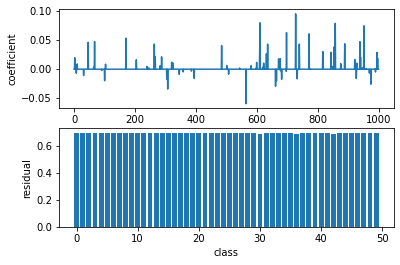

0.6439393939393939


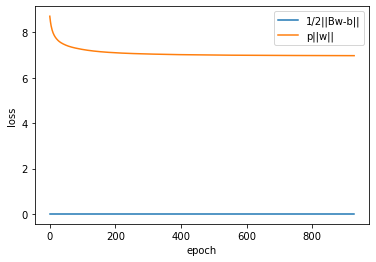

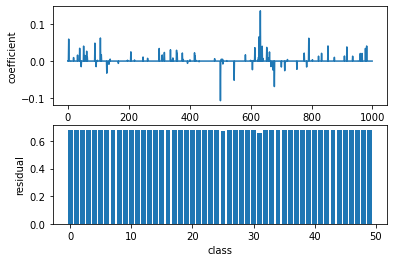

0.6466165413533834


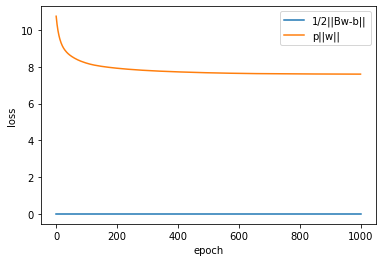

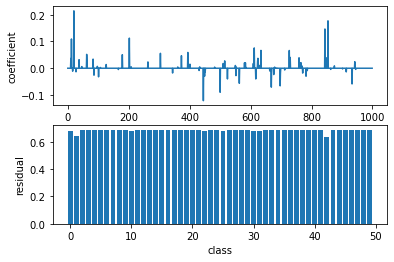

0.6417910447761194


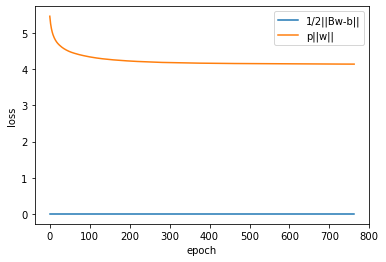

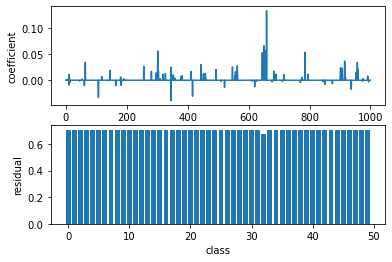

0.6444444444444445


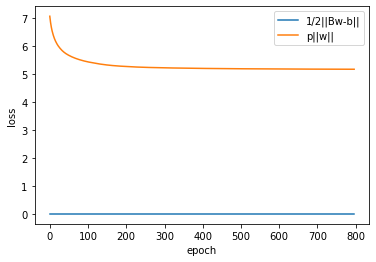

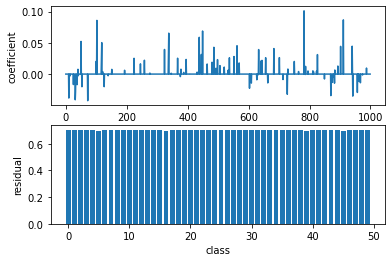

0.6397058823529411


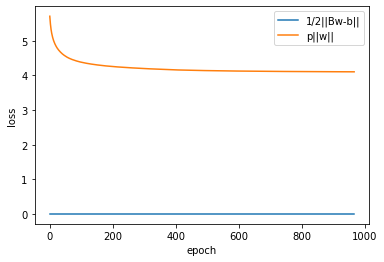

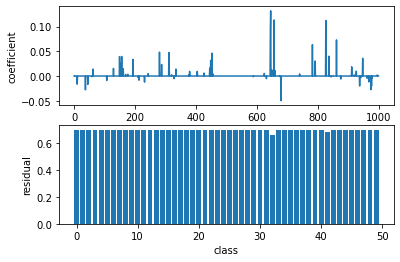

0.6423357664233577


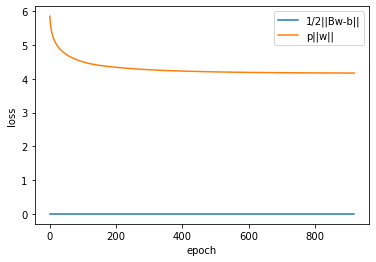

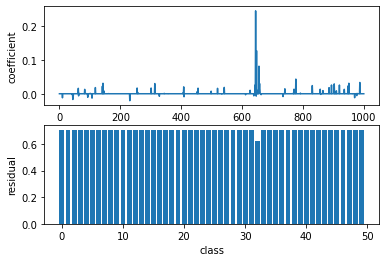

0.644927536231884


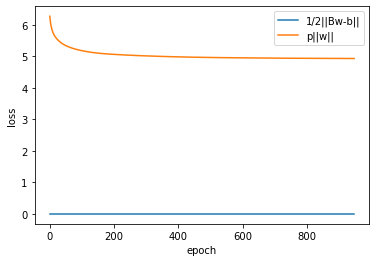

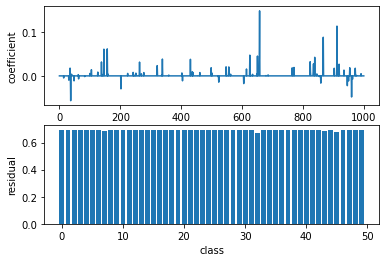

0.6474820143884892


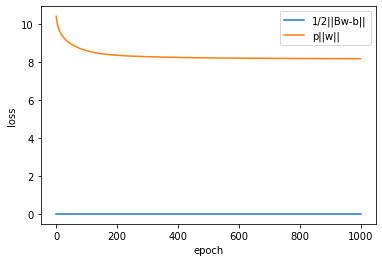

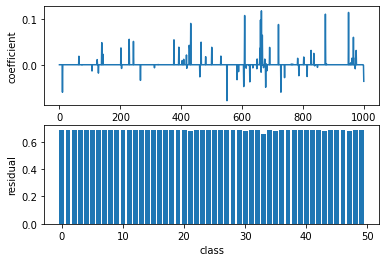

0.65


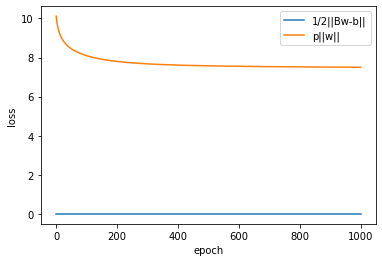

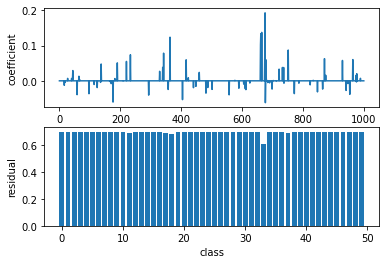

0.6524822695035462


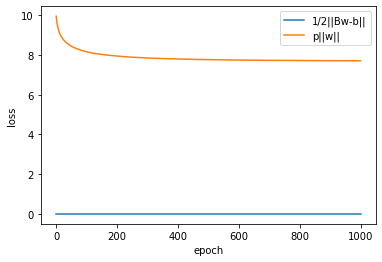

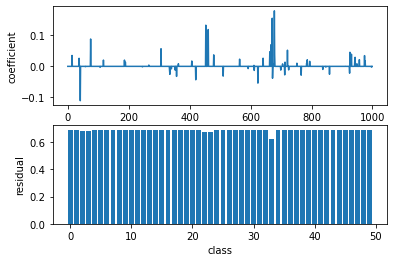

0.6549295774647887


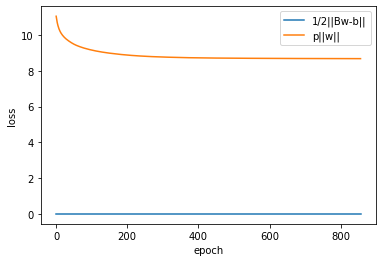

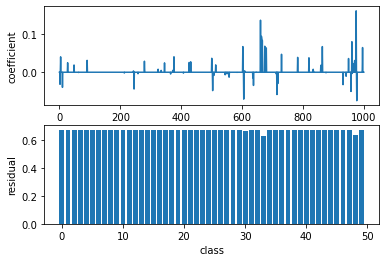

0.6573426573426573


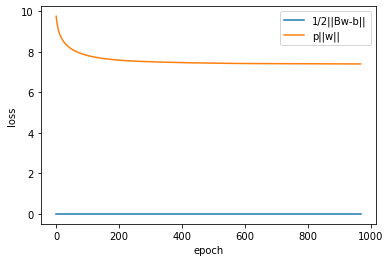

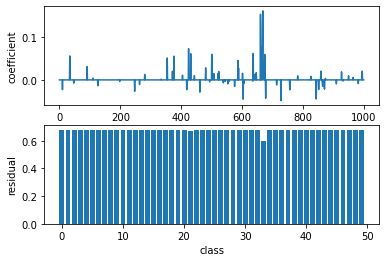

0.6597222222222222


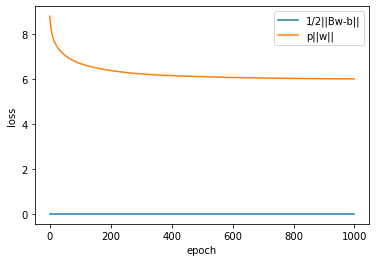

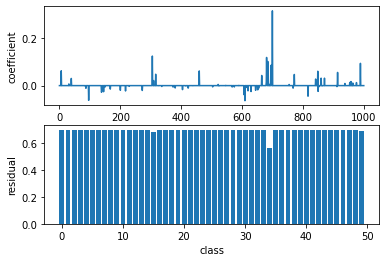

0.6620689655172414


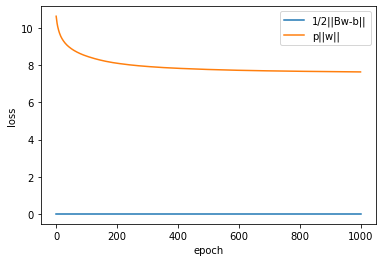

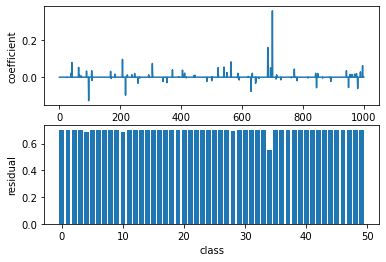

0.6643835616438356


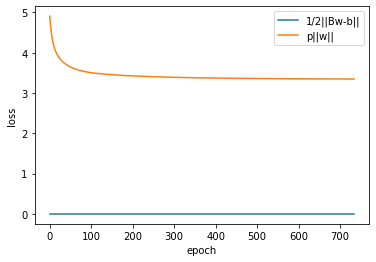

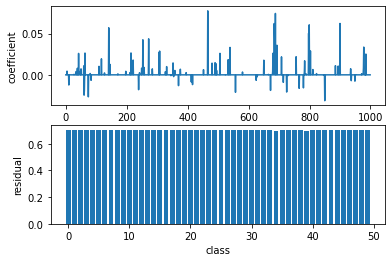

0.6666666666666666


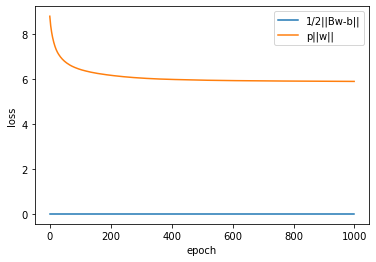

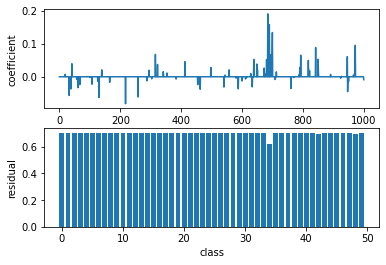

0.668918918918919


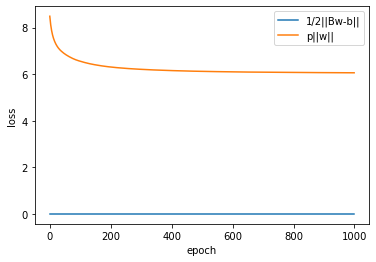

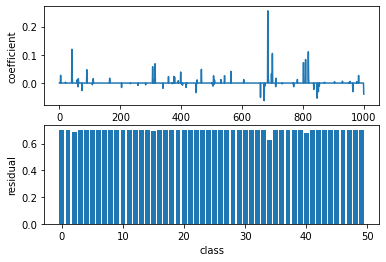

0.6711409395973155


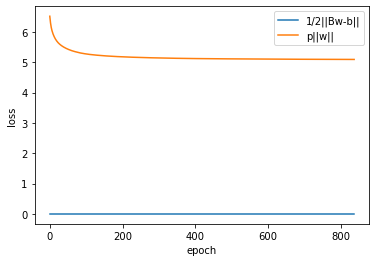

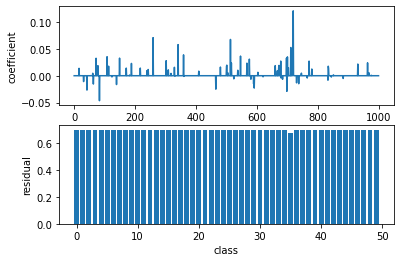

0.6733333333333333


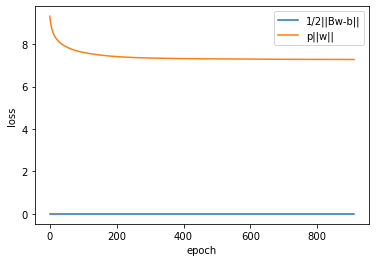

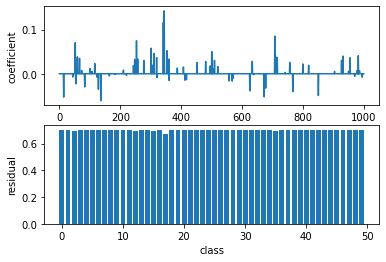

0.6688741721854304


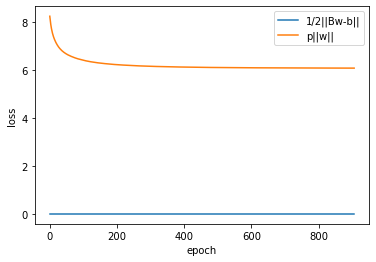

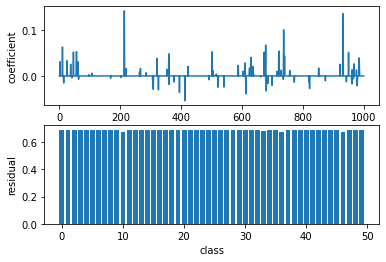

0.6644736842105263


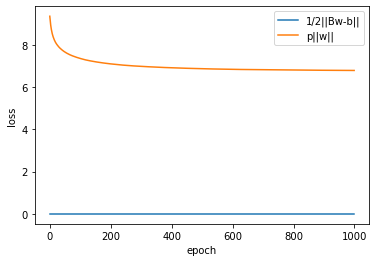

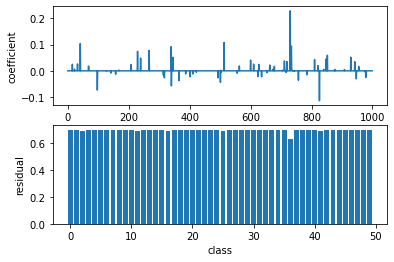

0.6666666666666666


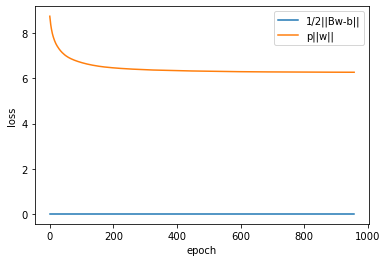

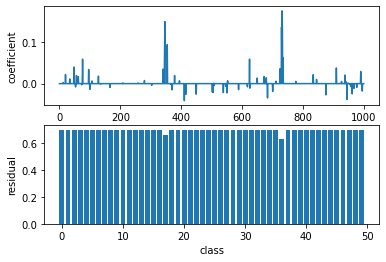

0.6688311688311688


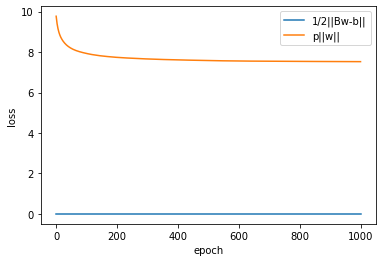

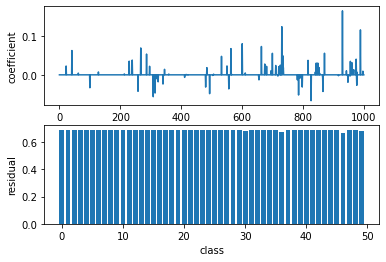

0.6645161290322581


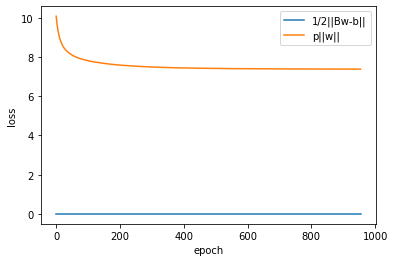

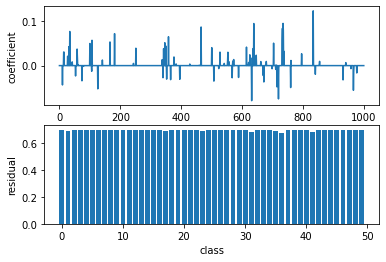

0.6666666666666666


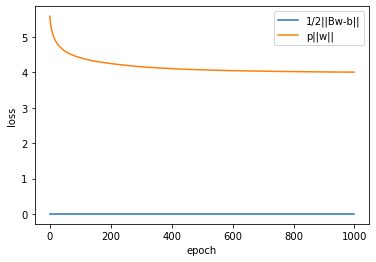

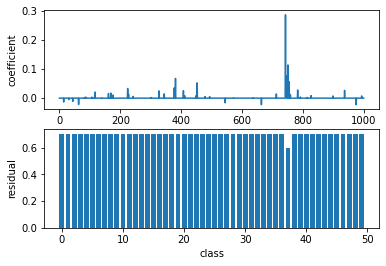

0.6687898089171974


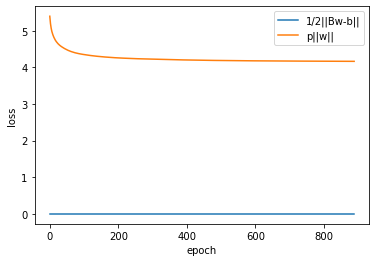

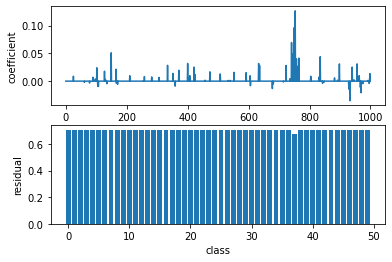

0.6708860759493671


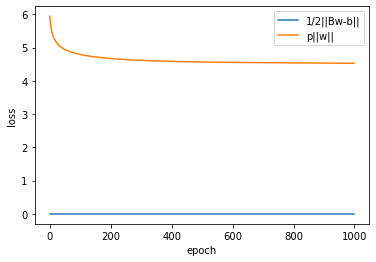

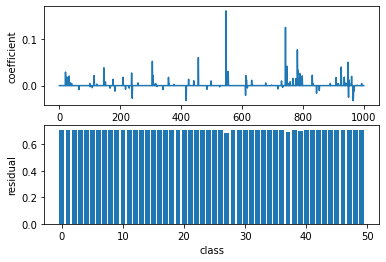

0.6666666666666666


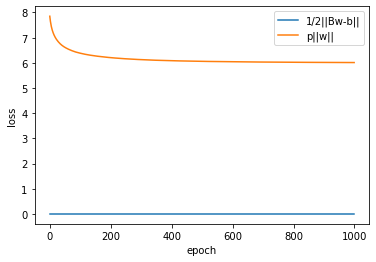

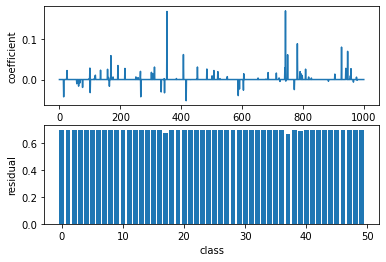

0.66875


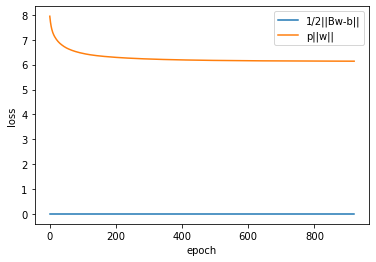

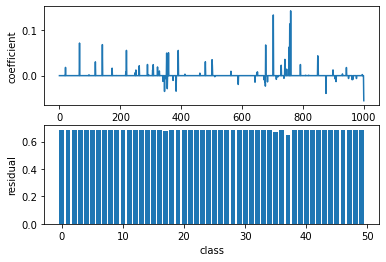

0.6708074534161491


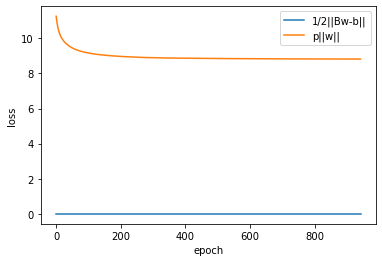

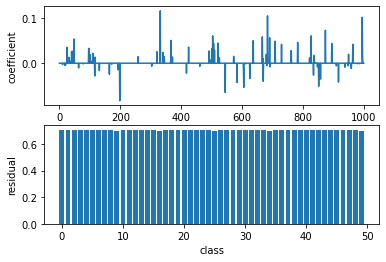

0.6666666666666666


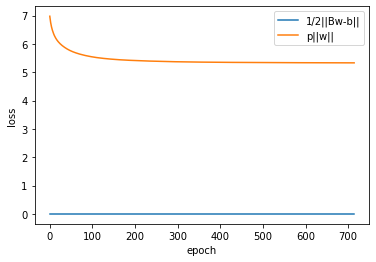

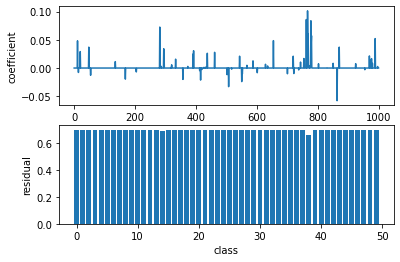

0.6687116564417178


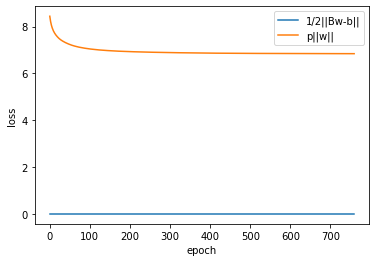

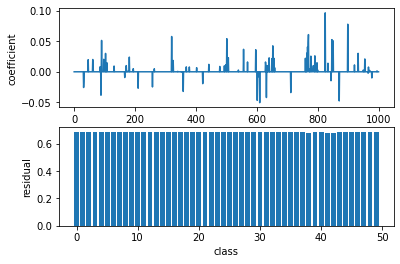

0.6646341463414634


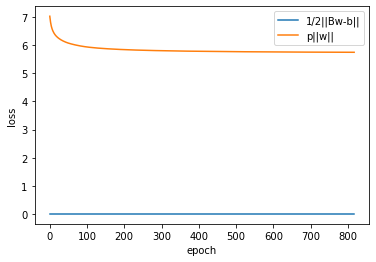

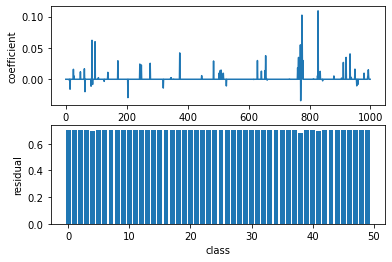

0.6666666666666666


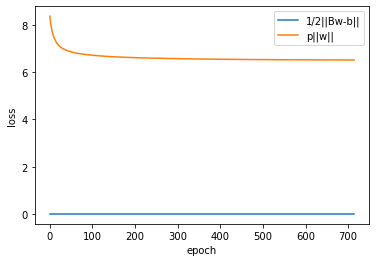

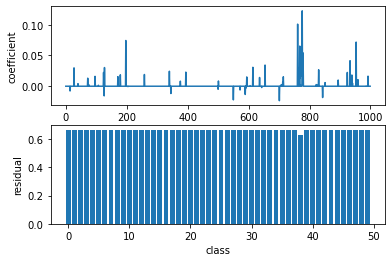

0.6686746987951807


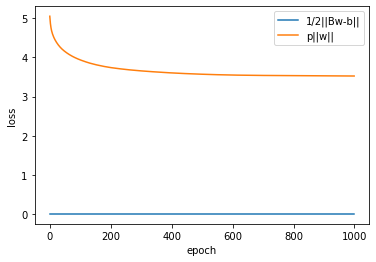

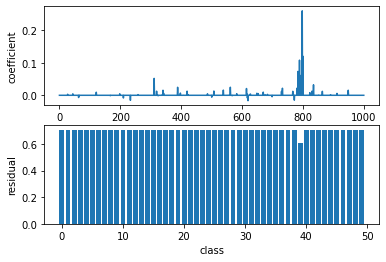

0.6706586826347305


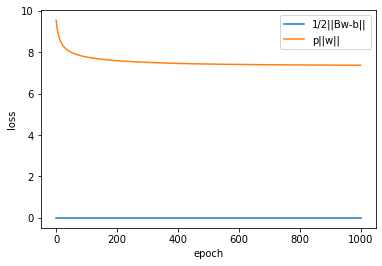

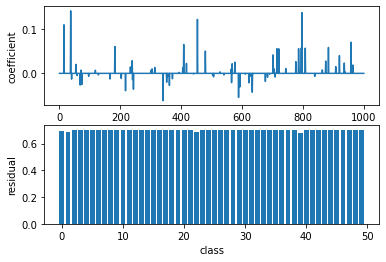

0.6726190476190477


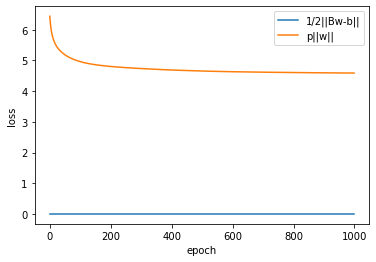

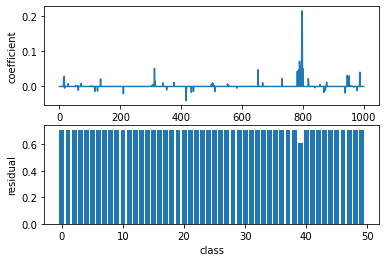

0.6745562130177515


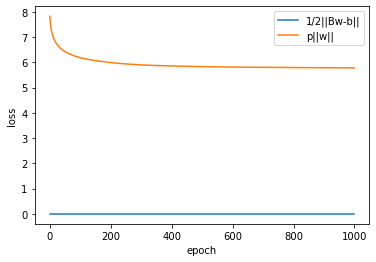

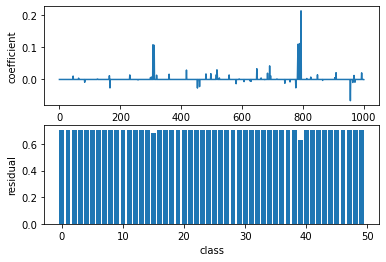

0.6764705882352942


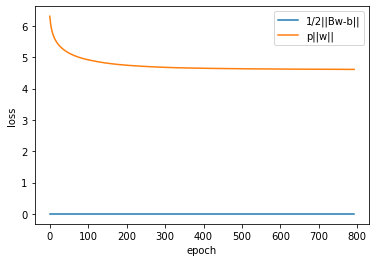

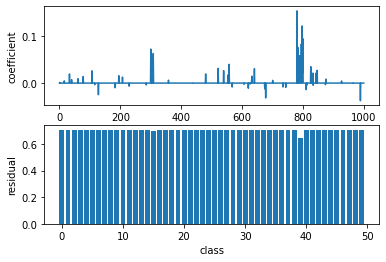

0.6783625730994152


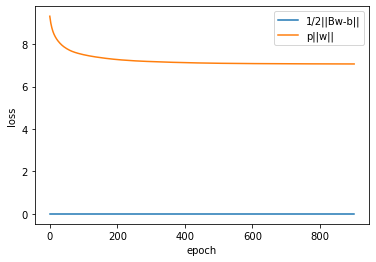

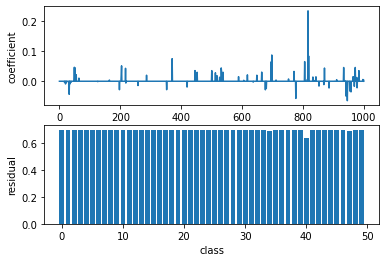

0.6802325581395349


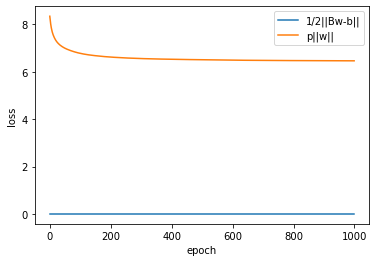

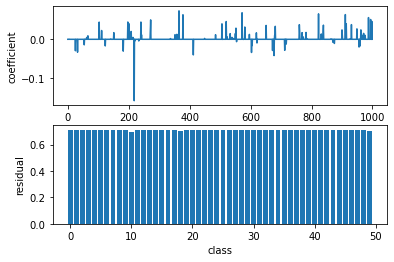

0.6763005780346821


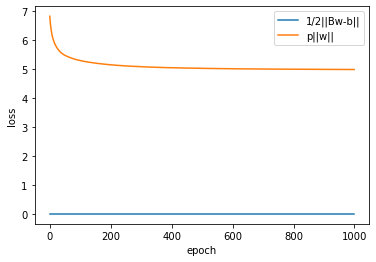

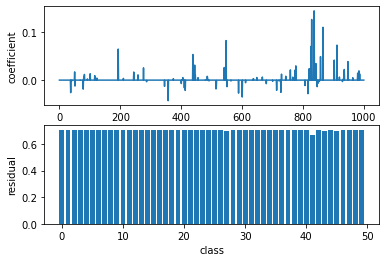

0.6781609195402298


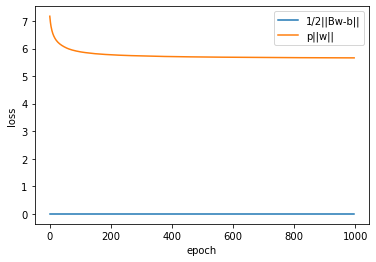

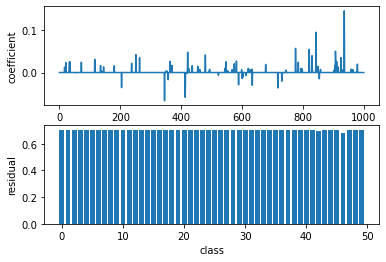

0.6742857142857143


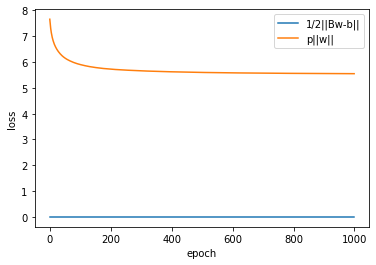

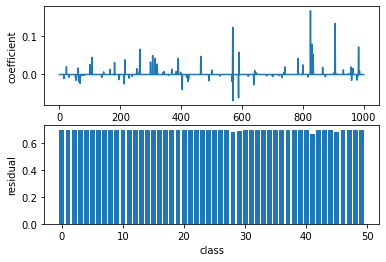

0.6761363636363636


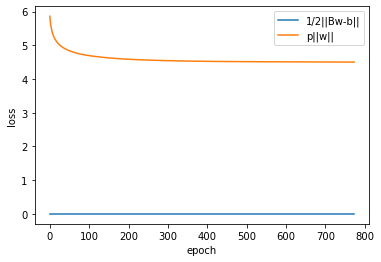

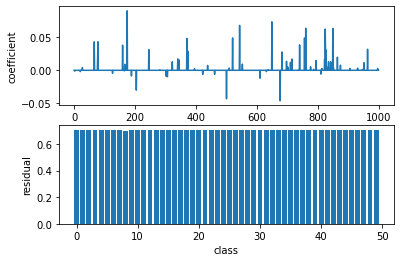

0.672316384180791


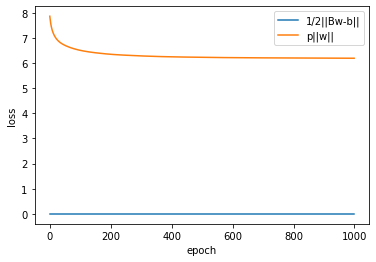

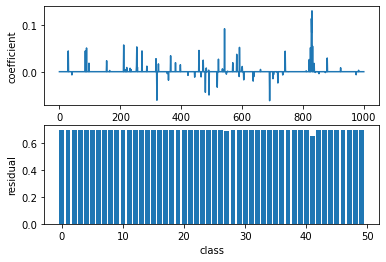

0.6741573033707865


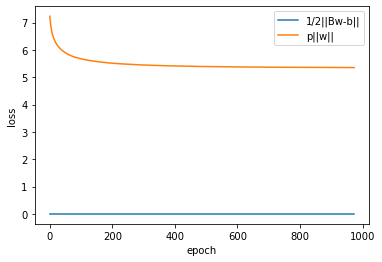

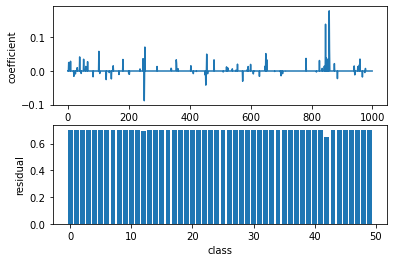

0.6759776536312849


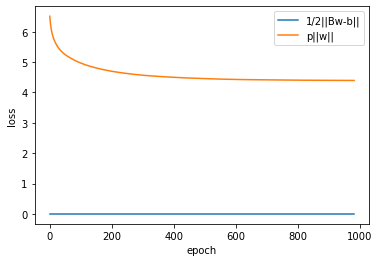

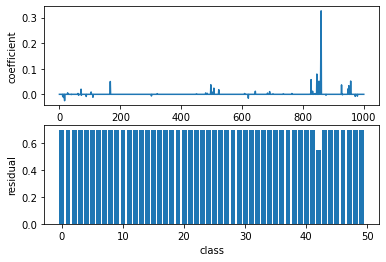

0.6777777777777778


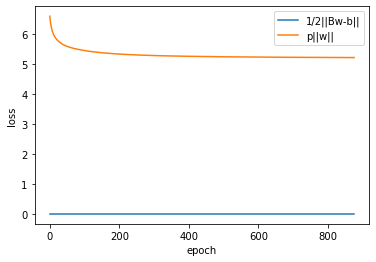

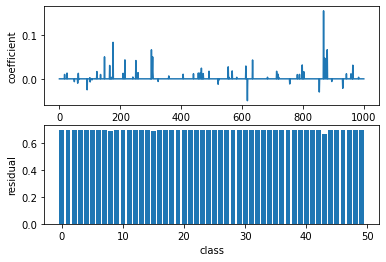

0.6795580110497238


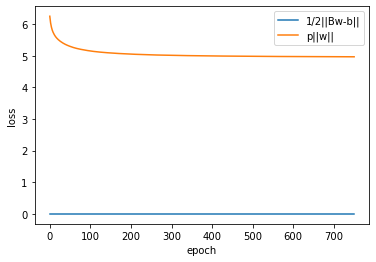

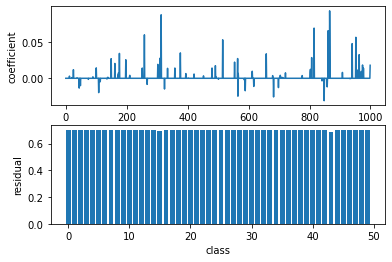

0.6813186813186813


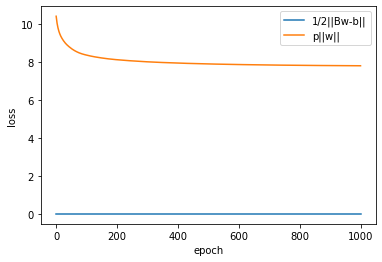

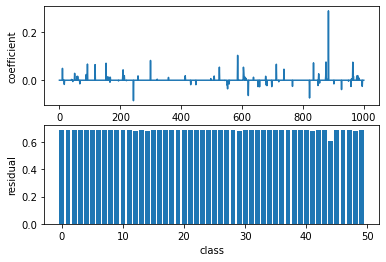

0.6775956284153005


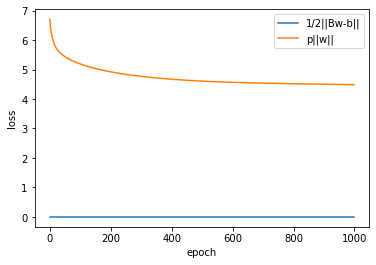

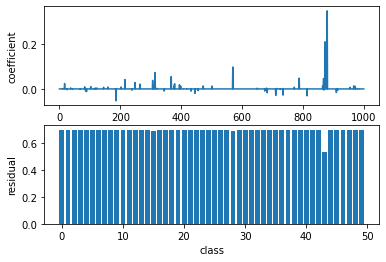

0.6793478260869565


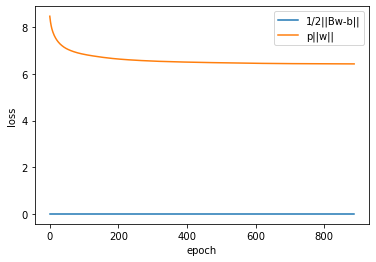

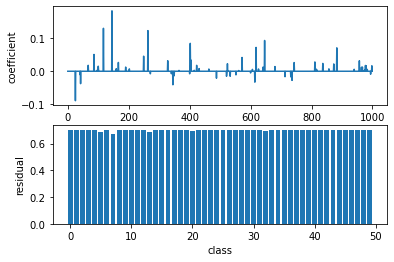

0.6756756756756757


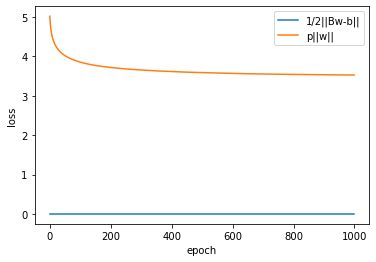

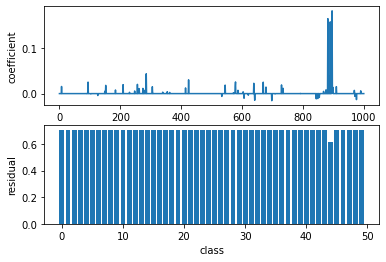

0.6774193548387096


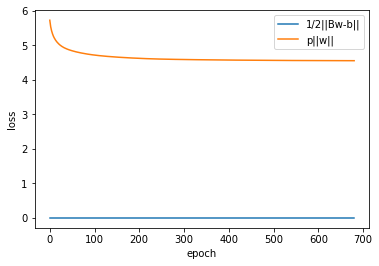

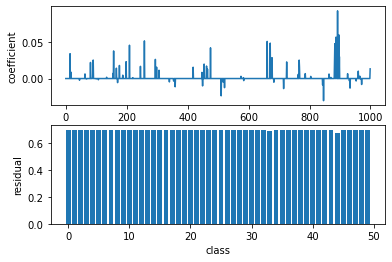

0.679144385026738


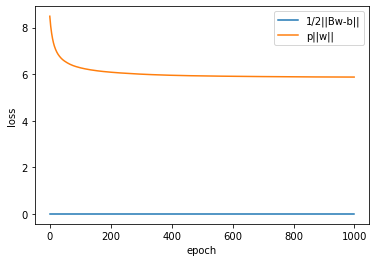

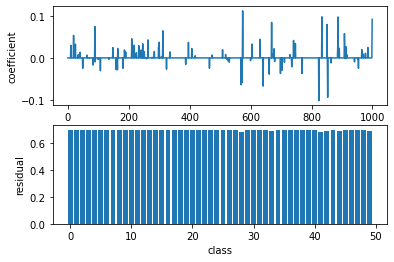

0.675531914893617


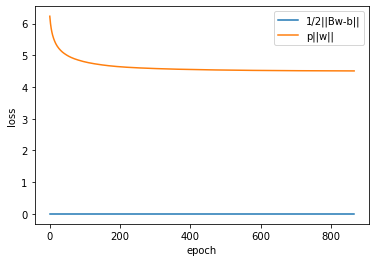

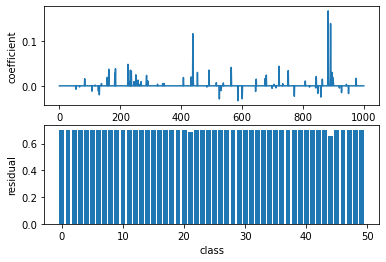

0.6772486772486772


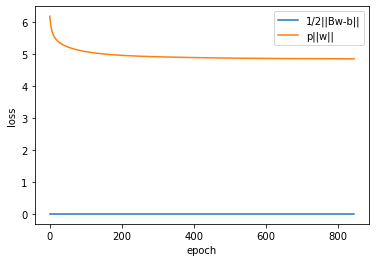

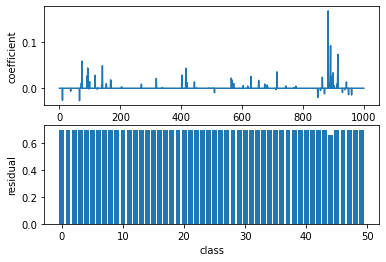

0.6789473684210526


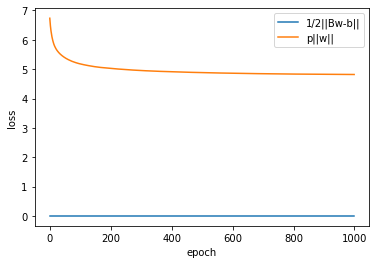

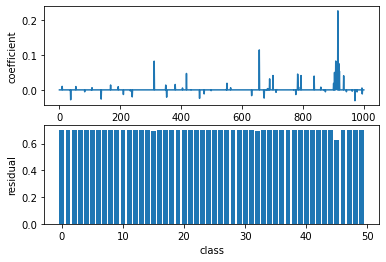

0.680628272251309


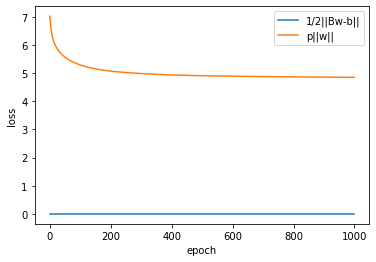

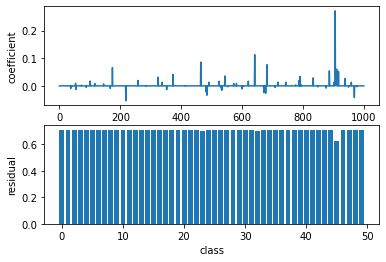

0.6822916666666666


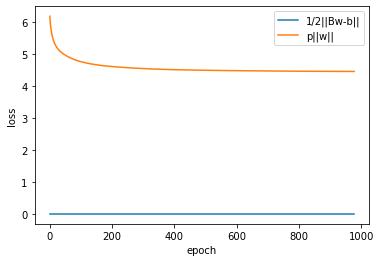

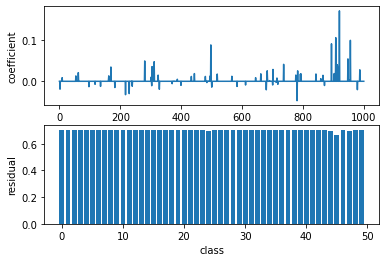

0.6839378238341969


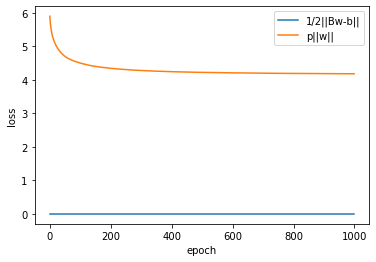

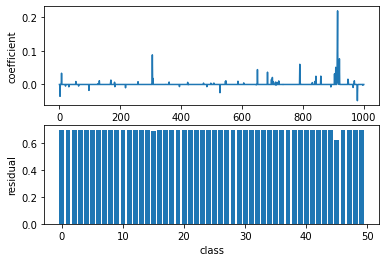

0.6855670103092784


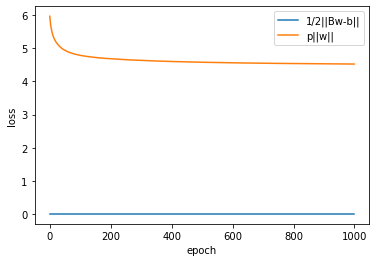

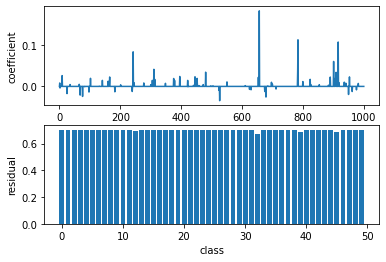

0.6820512820512821


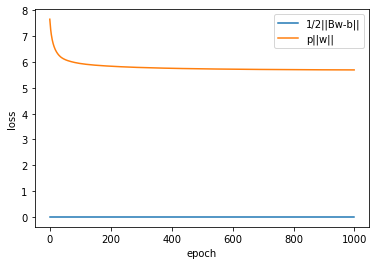

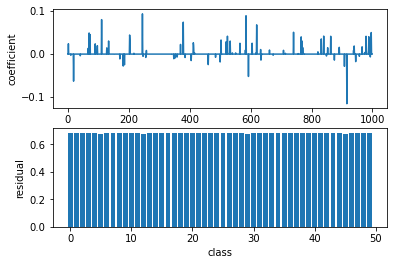

0.6785714285714286


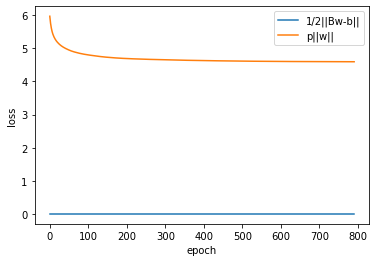

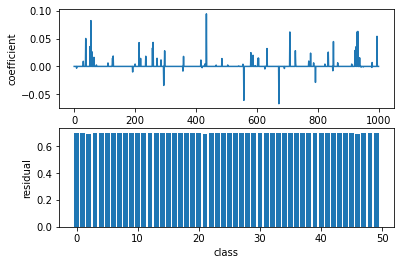

0.6802030456852792


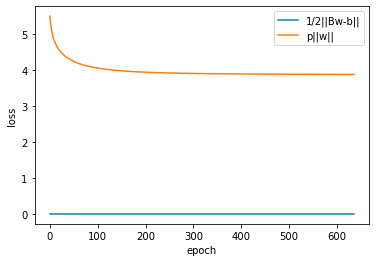

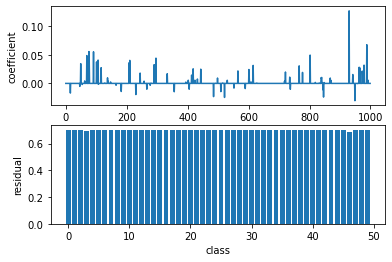

0.6818181818181818


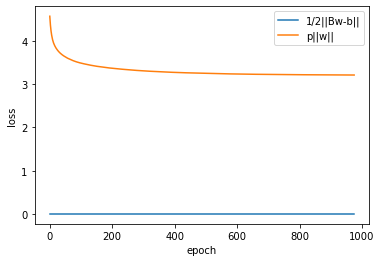

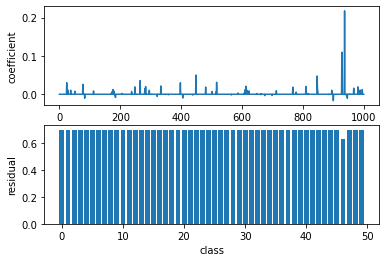

0.6834170854271356


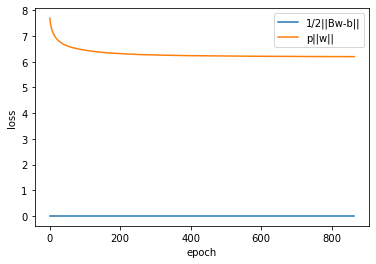

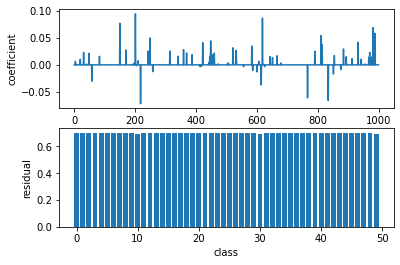

0.68


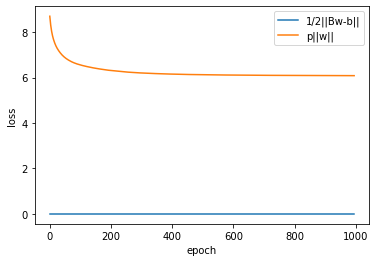

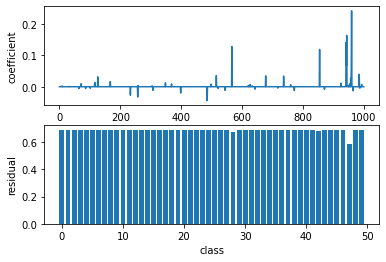

0.681592039800995


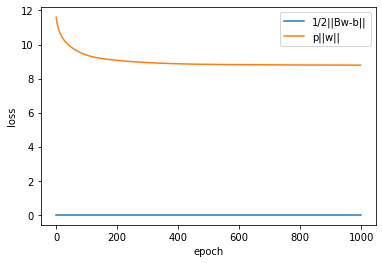

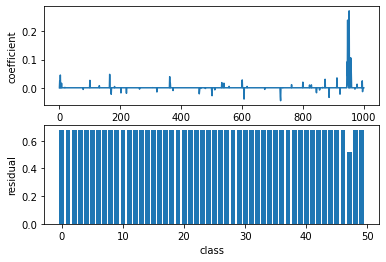

0.6831683168316832


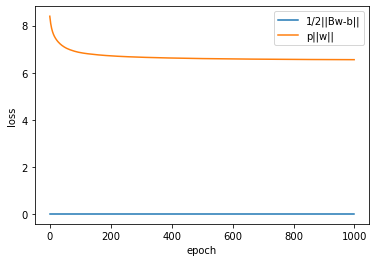

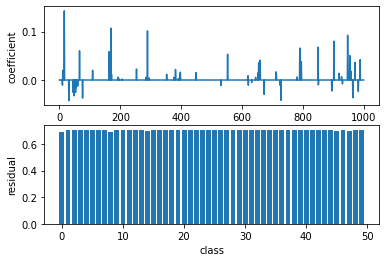

0.6798029556650246


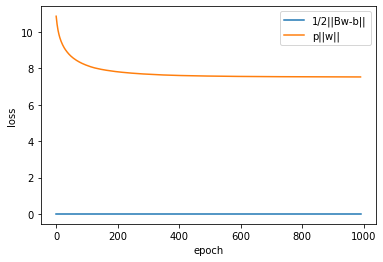

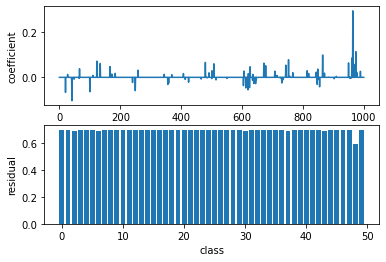

0.6813725490196079


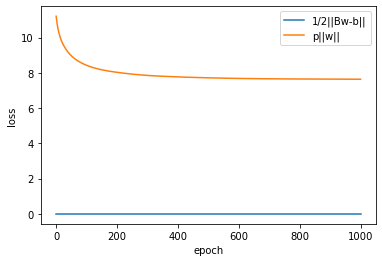

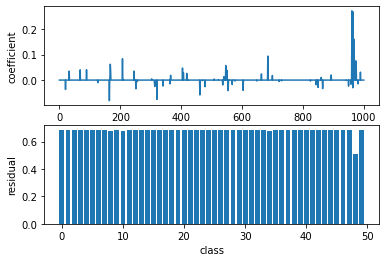

0.6829268292682927


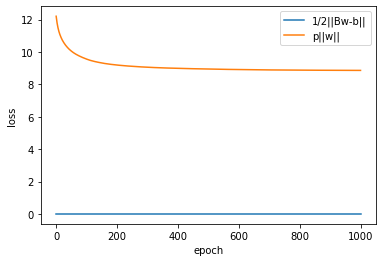

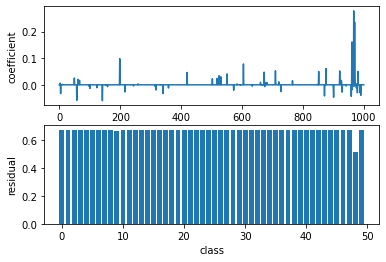

0.6844660194174758


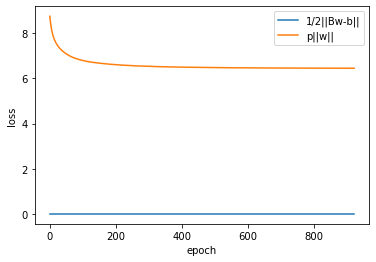

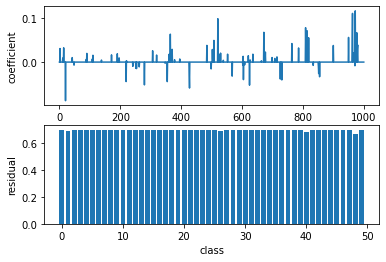

0.6859903381642513


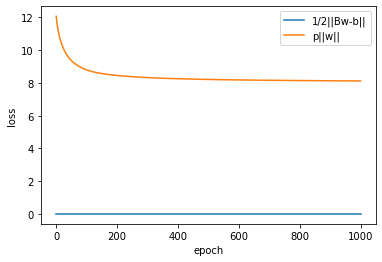

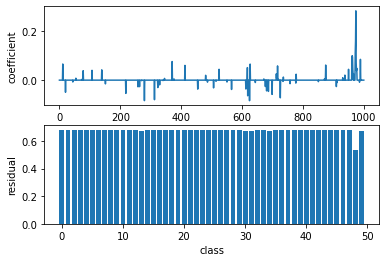

0.6875


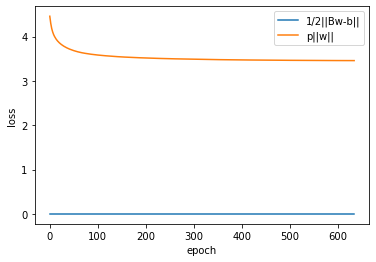

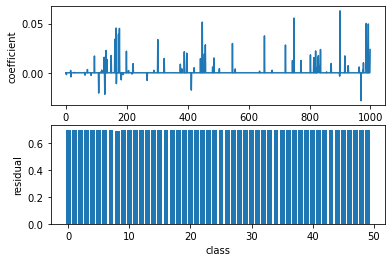

0.6842105263157895


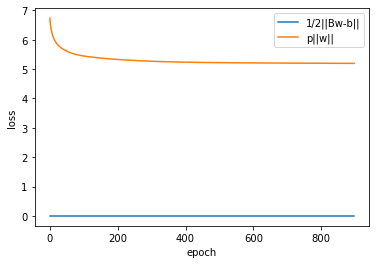

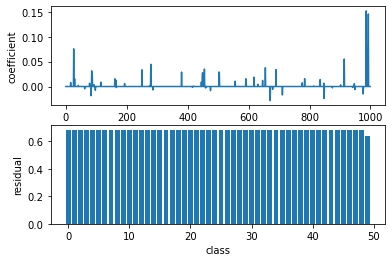

0.6857142857142857


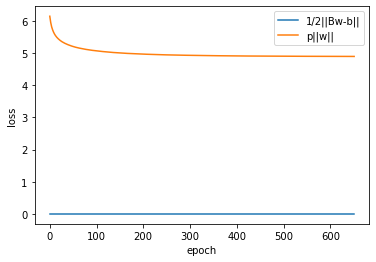

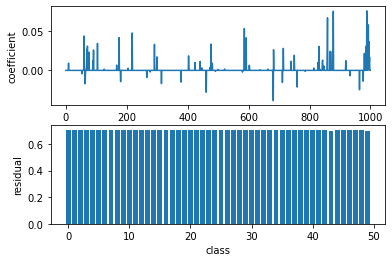

0.6872037914691943


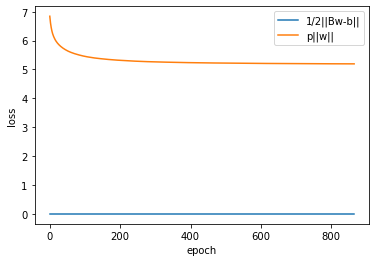

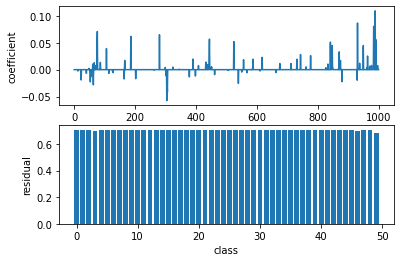

0.6886792452830188


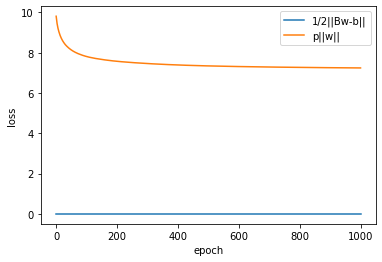

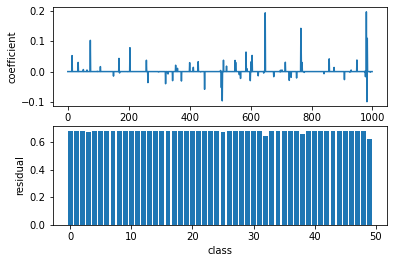

0.6901408450704225
测试结束，平均用时12.837s
accuracy=0.690


In [4]:
import time

correct = 0
total = 0
t_sta = time.time()
for classi in test_data:
    for y in test_data[classi]:
        src_i = sparse_representation_classify(RA, y, 1e-4, len(test_data), lasso_dalm, display=True)
        if src_i == class2index[classi]:
            correct += 1
        total += 1
        print(correct / total)
t_total = time.time() - t_sta
print("测试结束，平均用时{:.3f}s".format(t_total / total))
print("accuracy={:.3f}".format(correct / total))